# Income Prediction and Customer Segmentation for Marketing Strategy

## Overview

The objective of this notebook is to answer a practical marketing question using data:  
**who should be targeted, and how should different groups be approached?**

To address this, the analysis is structured into two connected parts:

1. **Income Prediction** – identifying individuals who are more likely to earn above $50,000  
2. **Customer Segmentation** – grouping individuals into meaningful segments to enable differentiated marketing strategies

Prediction helps decide **who to prioritize**, while segmentation helps decide **how to engage each group**.

---

## Thought Process and Approach

The analysis was approached in a step-by-step, business-oriented way:

1. **Data Understanding and Exploration**  
   The work began by exploring the demographic, employment, and financial variables to understand income distribution, class imbalance, and key patterns. This helped identify which features were likely to be informative and highlighted the need to focus on recall rather than accuracy due to the small proportion of high-income individuals.

2. **Income Prediction Modeling**  
   Multiple supervised learning models were tested using a consistent preprocessing and evaluation pipeline. Because missing a high-income individual is more costly than contacting a few additional lower-income individuals, model evaluation emphasized ROC-AUC and recall for the high-income class.  
   XGBoost was selected as the final model due to its strong performance, stable behavior across thresholds, and ability to provide clear insight into key drivers such as employment stability, education, occupation, and investment-related signals.

3. **Customer Segmentation**  
   To move beyond individual predictions, dimensionality reduction (PCA) and clustering (K-Means) were applied to group individuals with similar characteristics. Five segments were identified, each with distinct employment patterns, financial behavior, and income potential. These segments were translated into business-friendly profiles that can directly inform marketing strategy.

---

## Key Results

- **Affluent Professionals (0.2%)** represent the highest-value segment, with ~89% earning above $50K and strong investment activity.  
- **Investors with Gains (3.5%)** and **Investors with Losses (2.0%)** both show ~30% high-income rates, indicating strong potential for targeted financial and investment-related offerings.  
- **Working Mainstream (43%)** is a large volume segment with moderate income potential, best suited for mass-market strategies.  
- **Young / Dependents (51%)** have very low current income but represent a long-term opportunity for brand building and future conversion.


# Income Classification EDA
## Census Data Exploration for Marketing Segmentation

In [1]:
import warnings
from itertools import combinations

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    silhouette_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline as SkPipeline

from xgboost import XGBClassifier

import shap

import joblib

In [2]:
# Load the census data
df = pd.read_csv('output.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Total Rows: {df.shape[0]:,}")
print(f"Total Columns: {df.shape[1]}")

Dataset Shape: (199523, 42)
Total Rows: 199,523
Total Columns: 42


In [3]:
print("COLUMN NAMES AND DATA TYPES")

column_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes.values,
    'Non-Null Count': df.count().values,
    'Null Count': df.isnull().sum().values,
    'Unique Values': [df[col].nunique() for col in df.columns]
})

column_info

COLUMN NAMES AND DATA TYPES


Column Name Data Type  Non-Null Count  \
0                                          age     int64          199523   
1                              class of worker    object          199523   
2                     detailed industry recode     int64          199523   
3                   detailed occupation recode     int64          199523   
4                                    education    object          199523   
5                                wage per hour     int64          199523   
6                   enroll in edu inst last wk    object          199523   
7                                 marital stat    object          199523   
8                          major industry code    object          199523   
9                        major occupation code    object          199523   
10                                        race    object          199523   
11                             hispanic origin    object          198649   
12                                         sex    object          199523   
13                     member of a labor union    object          199523   
14                     reason for unemployment    object          199523   
15           full or part time employment stat    object          199523   
16                               capital gains     int64          199523   
17                              capital losses     int64          199523   
18                       dividends from stocks     int64          199523   
19                              tax filer stat    object          199523   
20                region of previous residence    object          199523   
21                 state of previous residence    object          199523   
22          detailed household and family stat    object          199523   
23     detailed household summary in household    object          199523   
24                                      weight   float64          199523   
25                migration code-change in msa    object          199523   
26                migration code-change in reg    object          199523   
27              migration code-move within reg    object          199523   
28               live in this house 1 year ago    object          199523   
29               migration prev res in sunbelt    object          199523   
30             num persons worked for employer     int64          199523   
31                     family members under 18    object          199523   
32                     country of birth father    object          199523   
33                     country of birth mother    object          199523   
34                       country of birth self    object          199523   
35                                 citizenship    object          199523   
36               own business or self employed     int64          199523   
37  fill inc questionnaire for veteran's admin    object          199523   
38                           veterans benefits     int64          199523   
39                        weeks worked in year     int64          199523   
40                                        year     int64          199523   
41                                       label    object          199523   

    Null Count  Unique Values  
0            0             91  
1            0              9  
2            0             52  
3            0             47  
4            0             17  
5            0           1240  
6            0              3  
7            0              7  
8            0             24  
9            0             15  
10           0              5  
11         874              9  
12           0              2  
13           0              3  
14           0              6  
15           0              8  
16           0            132  
17           0            113  
18           0           1478  
19           0              6  
20           0              6  
21           0             51  
22           0             38 

In [4]:
numerical_cols_auto = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols_auto = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNUMERICAL COLUMNS ({len(numerical_cols_auto)}):")
print("-" * 40)
for i, col in enumerate(numerical_cols_auto, 1):
    print(f"  {i:2}. {col}")

print(f"\nCATEGORICAL COLUMNS ({len(categorical_cols_auto)}):")
print("-" * 40)
for i, col in enumerate(categorical_cols_auto, 1):
    print(f"  {i:2}. {col}")


NUMERICAL COLUMNS (13):
----------------------------------------
   1. age
   2. detailed industry recode
   3. detailed occupation recode
   4. wage per hour
   5. capital gains
   6. capital losses
   7. dividends from stocks
   8. weight
   9. num persons worked for employer
  10. own business or self employed
  11. veterans benefits
  12. weeks worked in year
  13. year

CATEGORICAL COLUMNS (29):
----------------------------------------
   1. class of worker
   2. education
   3. enroll in edu inst last wk
   4. marital stat
   5. major industry code
   6. major occupation code
   7. race
   8. hispanic origin
   9. sex
  10. member of a labor union
  11. reason for unemployment
  12. full or part time employment stat
  13. tax filer stat
  14. region of previous residence
  15. state of previous residence
  16. detailed household and family stat
  17. detailed household summary in household
  18. migration code-change in msa
  19. migration code-change in reg
  20. migration code

In [5]:
continuous_numerical = [
    'age',
    'wage per hour',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'weight',
    'num persons worked for employer',
    'weeks worked in year'
]

numerical_as_categorical = [
    'detailed industry recode',
    'detailed occupation recode',
    'own business or self employed',
    'veterans benefits',
    'year'
]

# True categorical features
true_categorical = [col for col in categorical_cols_auto if col != 'label']

# Target variable
target = 'label'

print("REFINED COLUMN CLASSIFICATION")

print(f"\nCONTINUOUS NUMERICAL ({len(continuous_numerical)}):")
for col in continuous_numerical:
    if col in df.columns:
        print(f"   • {col}")

print(f"\nNUMERICAL AS CATEGORICAL ({len(numerical_as_categorical)}):")
for col in numerical_as_categorical:
    if col in df.columns:
        print(f"   • {col} (unique values: {df[col].nunique()})")

print(f"\nTRUE CATEGORICAL ({len(true_categorical)}):")
for col in true_categorical:
    if col in df.columns:
        print(f"   • {col} (unique values: {df[col].nunique()})")

print(f"\n TARGET VARIABLE: {target}")

REFINED COLUMN CLASSIFICATION

CONTINUOUS NUMERICAL (8):
   • age
   • wage per hour
   • capital gains
   • capital losses
   • dividends from stocks
   • weight
   • num persons worked for employer
   • weeks worked in year

NUMERICAL AS CATEGORICAL (5):
   • detailed industry recode (unique values: 52)
   • detailed occupation recode (unique values: 47)
   • own business or self employed (unique values: 3)
   • veterans benefits (unique values: 3)
   • year (unique values: 2)

TRUE CATEGORICAL (28):
   • class of worker (unique values: 9)
   • education (unique values: 17)
   • enroll in edu inst last wk (unique values: 3)
   • marital stat (unique values: 7)
   • major industry code (unique values: 24)
   • major occupation code (unique values: 15)
   • race (unique values: 5)
   • hispanic origin (unique values: 9)
   • sex (unique values: 2)
   • member of a labor union (unique values: 3)
   • reason for unemployment (unique values: 6)
   • full or part time employment stat (uniq

In [6]:
NUMERICAL_FEATURES = [col for col in continuous_numerical if col in df.columns and col != 'weight']
CATEGORICAL_FEATURES = true_categorical + [col for col in numerical_as_categorical if col in df.columns]
TARGET = 'label'
WEIGHT_COL = 'weight'

print("FINAL FEATURE LISTS")

print(f"\nNUMERICAL_FEATURES = {NUMERICAL_FEATURES}")
print(f"\nTotal Numerical: {len(NUMERICAL_FEATURES)}")
print(f"Total Categorical: {len(CATEGORICAL_FEATURES)}")
print(f"\nTarget: {TARGET}")
print(f"Weight Column: {WEIGHT_COL}")

FINAL FEATURE LISTS

NUMERICAL_FEATURES = ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'weeks worked in year']

Total Numerical: 7
Total Categorical: 33

Target: label
Weight Column: weight



## Exploratory Data Analysis (EDA)


In [7]:
sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=0.9
)

mpl.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 150,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})


In [8]:
# Summary statistics for numerical columns
print("NUMERICAL COLUMNS - DESCRIPTIVE STATISTICS")

numerical_stats = df[NUMERICAL_FEATURES].describe().T
numerical_stats['median'] = df[NUMERICAL_FEATURES].median()
numerical_stats['skewness'] = df[NUMERICAL_FEATURES].skew()

numerical_stats

NUMERICAL COLUMNS - DESCRIPTIVE STATISTICS


count        mean          std  min   25%  \
age                              199523.0   34.494199    22.310895  0.0  15.0   
wage per hour                    199523.0   55.426908   274.896454  0.0   0.0   
capital gains                    199523.0  434.718990  4697.531280  0.0   0.0   
capital losses                   199523.0   37.313788   271.896428  0.0   0.0   
dividends from stocks            199523.0  197.529533  1984.163658  0.0   0.0   
num persons worked for employer  199523.0    1.956180     2.365126  0.0   0.0   
weeks worked in year             199523.0   23.174897    24.411488  0.0   0.0   

                                  50%   75%      max  median   skewness  
age                              33.0  50.0     90.0    33.0   0.373290  
wage per hour                     0.0   0.0   9999.0     0.0   8.935097  
capital gains                     0.0   0.0  99999.0     0.0  18.990822  
capital losses                    0.0   0.0   4608.0     0.0   7.632565  
dividends from stocks             0.0   0.0  99999.0     0.0  27.786502  
num persons worked for employer   1.0   4.0      6.0     1.0   0.751561  
weeks worked in year              8.0  52.0     52.0     8.0   0.210169

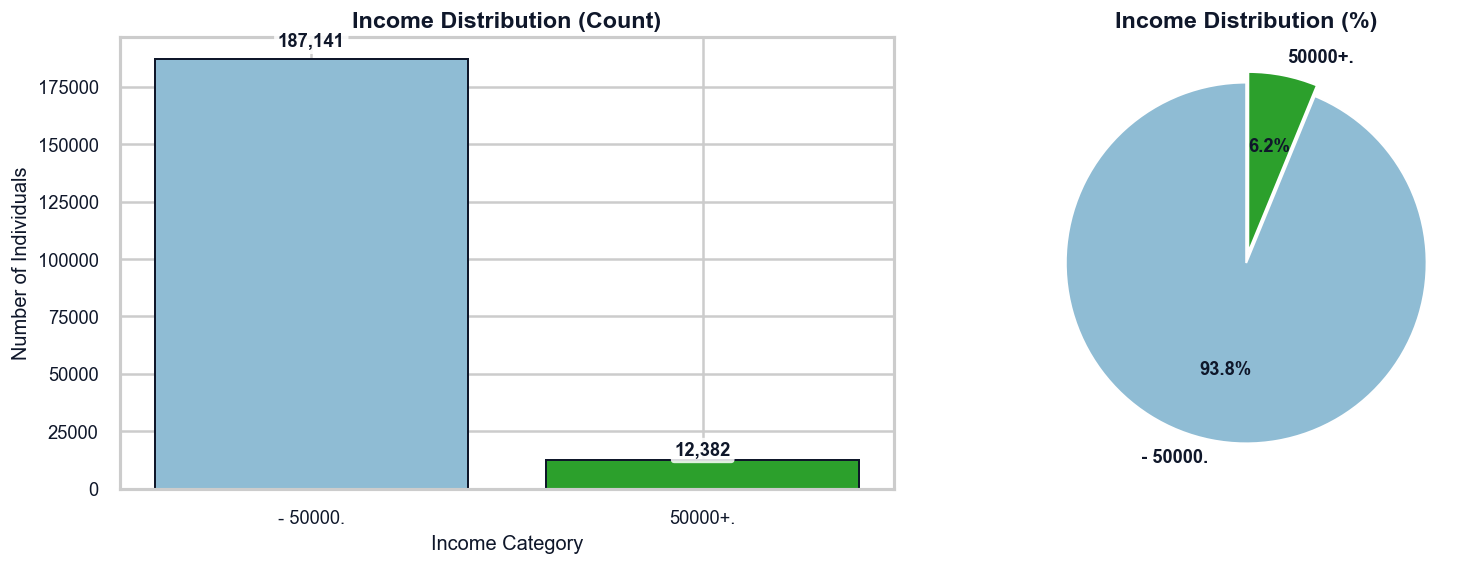

In [9]:
# EDA – Target Distribution
target_counts = df[TARGET].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ["#8fbcd4", "#2ca02c"]

text_color = "#0f172a"

# ---- Bar Chart ----
bars = axes[0].bar(
    target_counts.index,
    target_counts.values,
    color=colors,
    edgecolor=text_color,
    linewidth=1.2
)

axes[0].set_title("Income Distribution (Count)", fontweight="bold", color=text_color)
axes[0].set_xlabel("Income Category", color=text_color)
axes[0].set_ylabel("Number of Individuals", color=text_color)

axes[0].tick_params(colors=text_color)

for bar in bars:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height * 1.02,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
        color=text_color,
        bbox=dict(
            facecolor="white",
            edgecolor="none",
            alpha=0.85,
            boxstyle="round,pad=0.2"
        )
    )

# ---- Pie Chart ----
axes[1].pie(
    target_counts.values,
    labels=target_counts.index,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=(0, 0.06),
    textprops={
        "fontsize": 11,
        "fontweight": "bold",
        "color": text_color
    },
    wedgeprops={
        "edgecolor": "white",
        "linewidth": 1.2
    }
)

axes[1].set_title("Income Distribution (%)", fontweight="bold", color=text_color)

plt.tight_layout()
plt.show()


WEIGHT COLUMN ANALYSIS

Weight Statistics:
  Min: 37.87
  Max: 18656.30
  Mean: 1740.38
  Median: 1618.31

Total sample size: 199,523
Weighted population represented: 347,245,892

Interpretation:
  Each record represents between 38 and 18656 people
  in the actual US population due to stratified sampling.


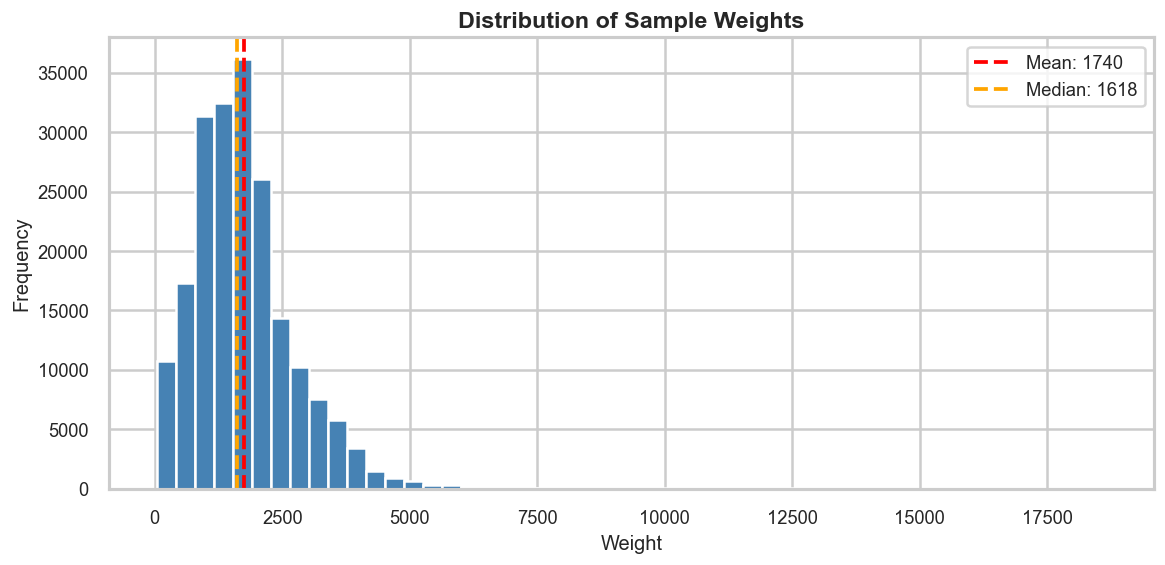

In [10]:
# WEIGHT COLUMN ANALYSIS

print("WEIGHT COLUMN ANALYSIS")


print(f"\nWeight Statistics:")
print(f"  Min: {df['weight'].min():.2f}")
print(f"  Max: {df['weight'].max():.2f}")
print(f"  Mean: {df['weight'].mean():.2f}")
print(f"  Median: {df['weight'].median():.2f}")

print(f"\nTotal sample size: {len(df):,}")
print(f"Weighted population represented: {df['weight'].sum():,.0f}")

print(f"\nInterpretation:")
print(f"  Each record represents between {df['weight'].min():.0f} and {df['weight'].max():.0f} people")
print(f"  in the actual US population due to stratified sampling.")

# Visualize weight distribution
fig, ax = plt.subplots(figsize=(10, 5))
df['weight'].hist(bins=50, ax=ax, color='steelblue', edgecolor='white')
ax.set_title('Distribution of Sample Weights', fontweight='bold')
ax.set_xlabel('Weight')
ax.set_ylabel('Frequency')
ax.axvline(df['weight'].mean(), color='red', linestyle='--', label=f"Mean: {df['weight'].mean():.0f}")
ax.axvline(df['weight'].median(), color='orange', linestyle='--', label=f"Median: {df['weight'].median():.0f}")
ax.legend()
plt.tight_layout()
plt.show()

MISSING VALUES ANALYSIS

Standard NULL Values:
hispanic origin    874
dtype: int64

'?' Placeholder Values (Missing Data):
   • migration code-change in msa: 99,696 (49.97%)
   • migration code-change in reg: 99,696 (49.97%)
   • migration code-move within reg: 99,696 (49.97%)
   • migration prev res in sunbelt: 99,696 (49.97%)
   • country of birth father: 6,713 (3.36%)
   • country of birth mother: 6,119 (3.07%)
   • country of birth self: 3,393 (1.70%)
   • state of previous residence: 708 (0.35%)


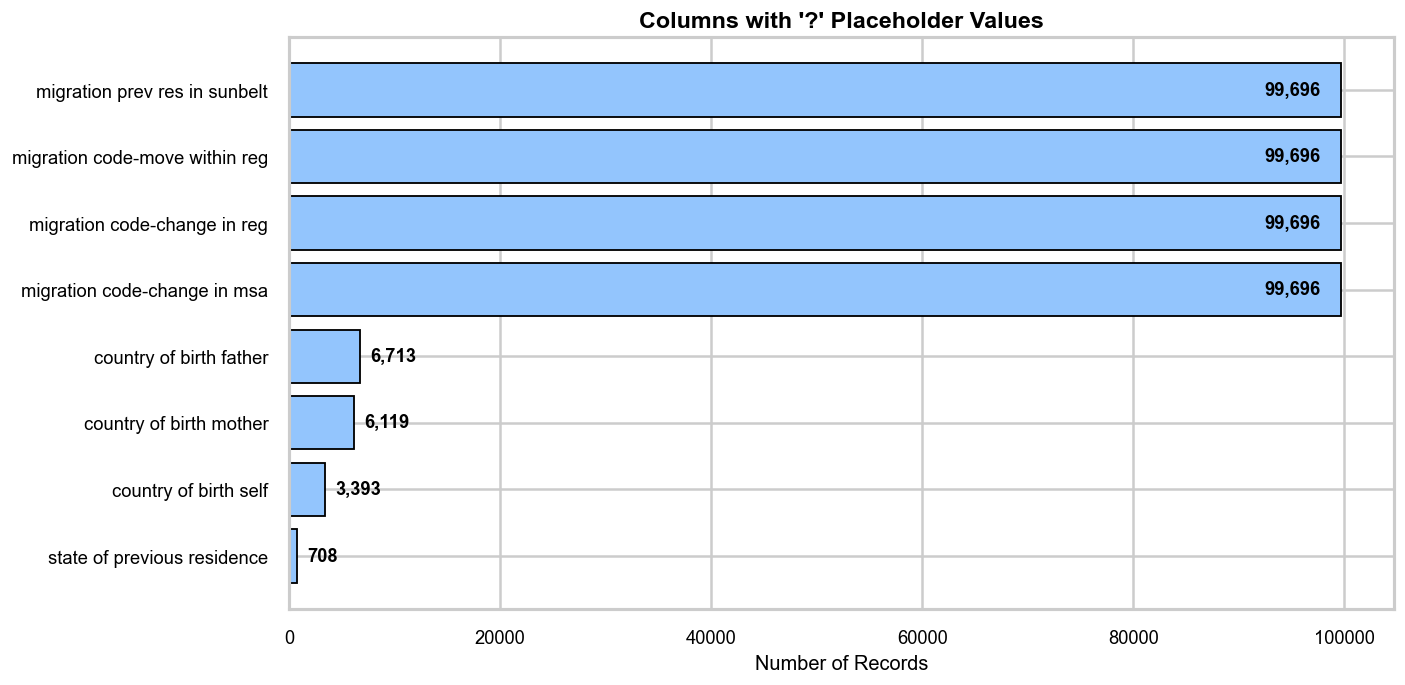

In [11]:
# EDA – Missing Values Analysis

print("MISSING VALUES ANALYSIS")

null_counts = df.isnull().sum()
null_pct = (null_counts / len(df)) * 100

# Check for '?' placeholders
question_mark_counts = {
    col: (df[col] == '?').sum()
    for col in df.columns
    if df[col].dtype == 'object' and (df[col] == '?').sum() > 0
}

print("\nStandard NULL Values:")
if null_counts.sum() == 0:
    print("No standard NULL values found!")
else:
    print(null_counts[null_counts > 0])

print("\n'?' Placeholder Values (Missing Data):")
if question_mark_counts:
    for col, count in sorted(question_mark_counts.items(), key=lambda x: -x[1]):
        pct = count / len(df) * 100
        print(f"   • {col}: {count:,} ({pct:.2f}%)")
else:
    print("No '?' placeholders found!")

if question_mark_counts:
    miss_df = (
        pd.DataFrame.from_dict(
            question_mark_counts,
            orient="index",
            columns=["Missing Count"]
        )
        .sort_values("Missing Count")
    )

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_color = "#93c5fd"   
    text_color = "#000000"  

    bars = ax.barh(
        miss_df.index,
        miss_df["Missing Count"],
        color=bar_color,
        edgecolor=text_color,
        linewidth=1.1
    )

    ax.set_title(
        "Columns with '?' Placeholder Values",
        fontweight="bold",
        color=text_color
    )
    ax.set_xlabel("Number of Records", color=text_color)
    ax.tick_params(colors=text_color)

    max_val = miss_df["Missing Count"].max()

    for bar in bars:
        width = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2

        if width > 0.25 * max_val:
            ax.text(
                width - max_val * 0.02,
                y,
                f"{int(width):,}",
                va="center",
                ha="right",
                fontsize=11,
                fontweight="bold",
                color=text_color
            )
        else:
            ax.text(
                width + max_val * 0.01,
                y,
                f"{int(width):,}",
                va="center",
                ha="left",
                fontsize=11,
                fontweight="bold",
                color=text_color
            )

    plt.tight_layout()
    plt.show()


NUMERICAL FEATURES - DISTRIBUTIONS


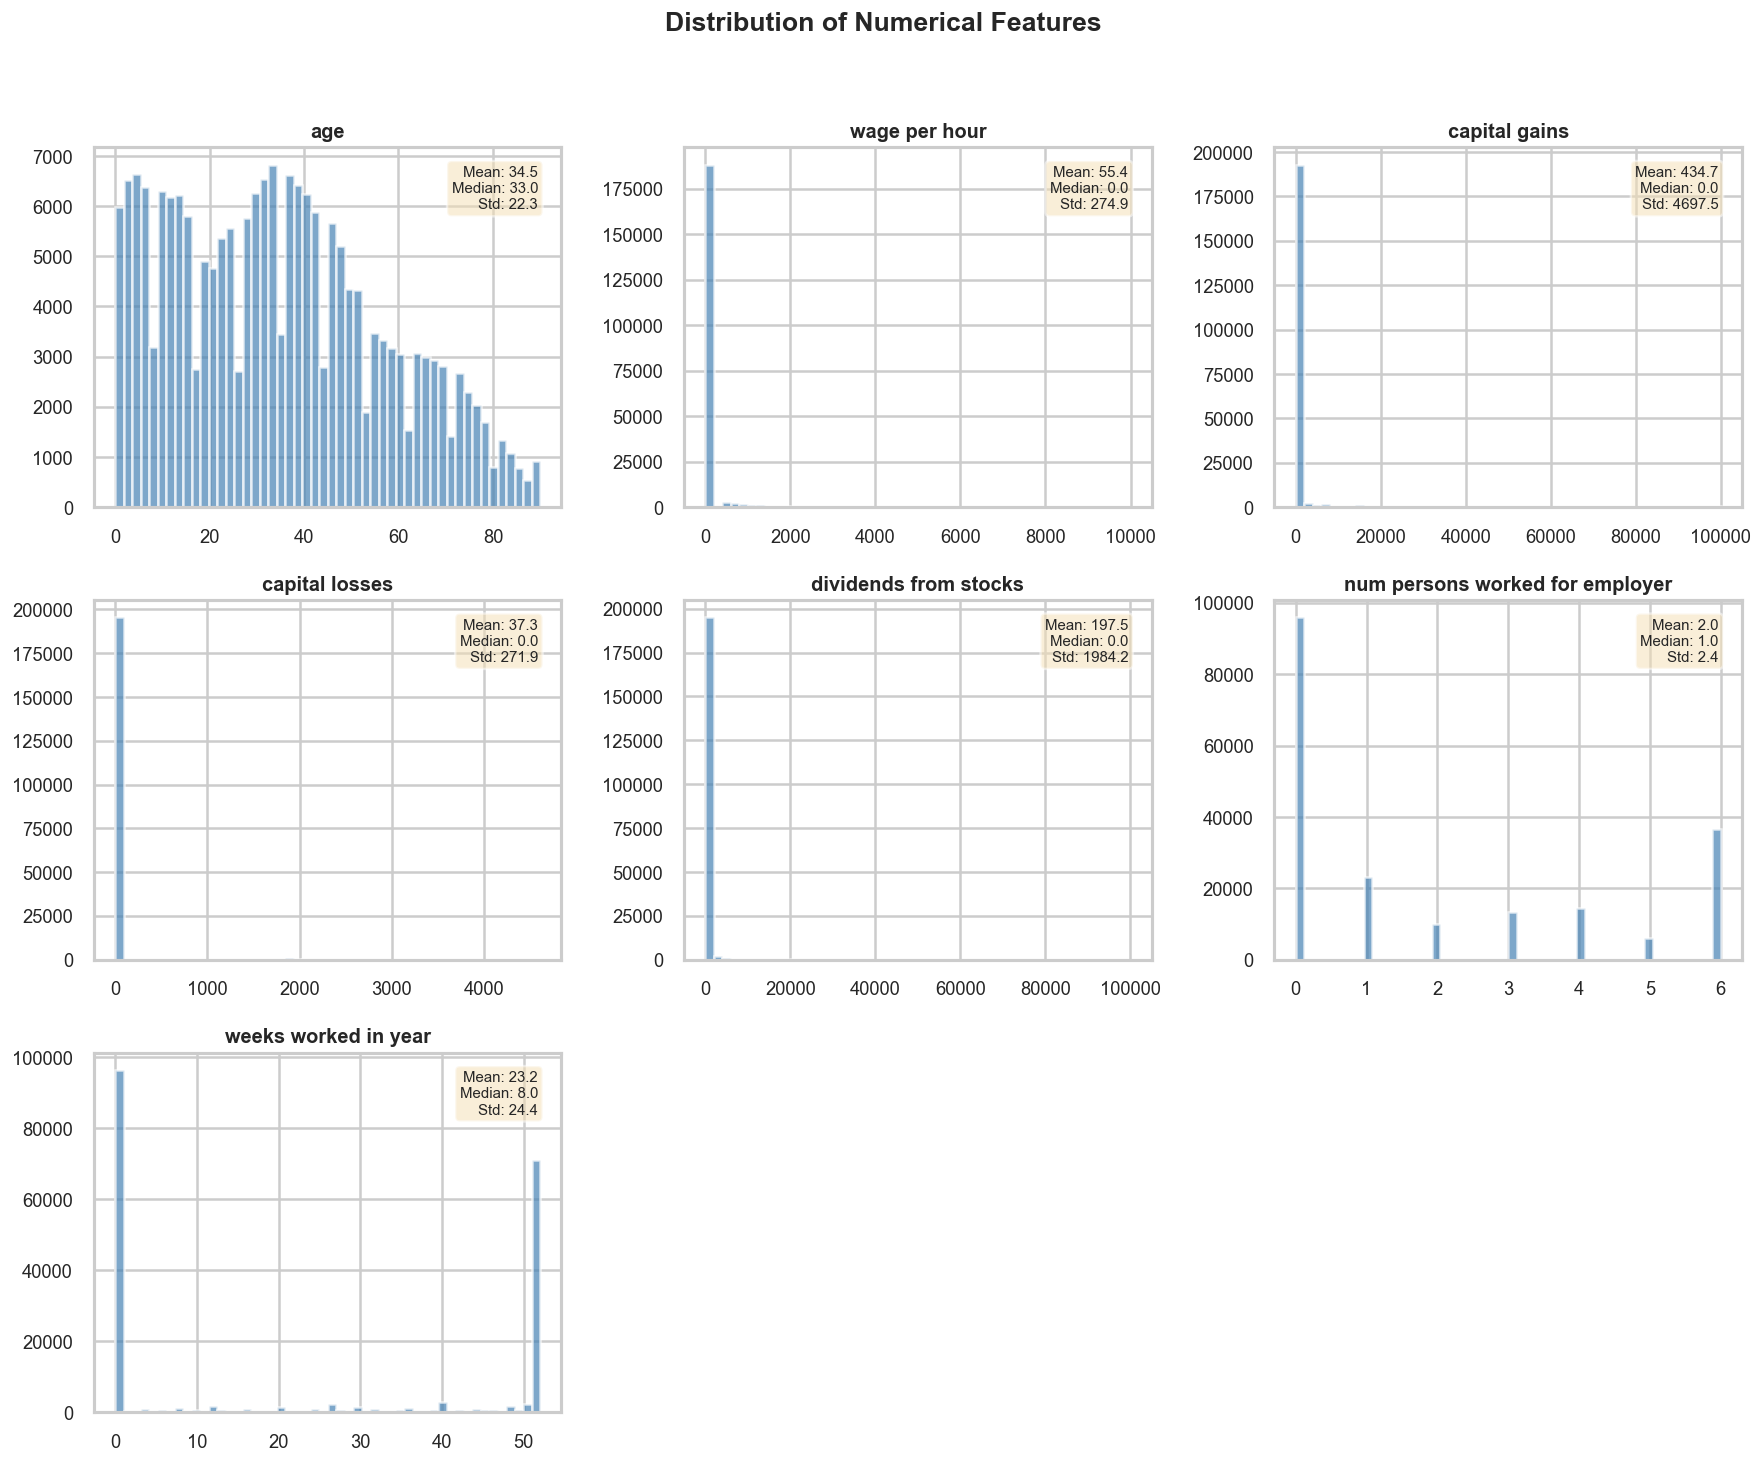

In [12]:
# Distribution of numerical features
print("NUMERICAL FEATURES - DISTRIBUTIONS")

n_features = len(NUMERICAL_FEATURES)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMERICAL_FEATURES):
    ax = axes[i]
    
    df[col].hist(bins=50, ax=ax, color='steelblue', edgecolor='white', alpha=0.7)
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    
    stats_text = f'Mean: {df[col].mean():.1f}\nMedian: {df[col].median():.1f}\nStd: {df[col].std():.1f}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

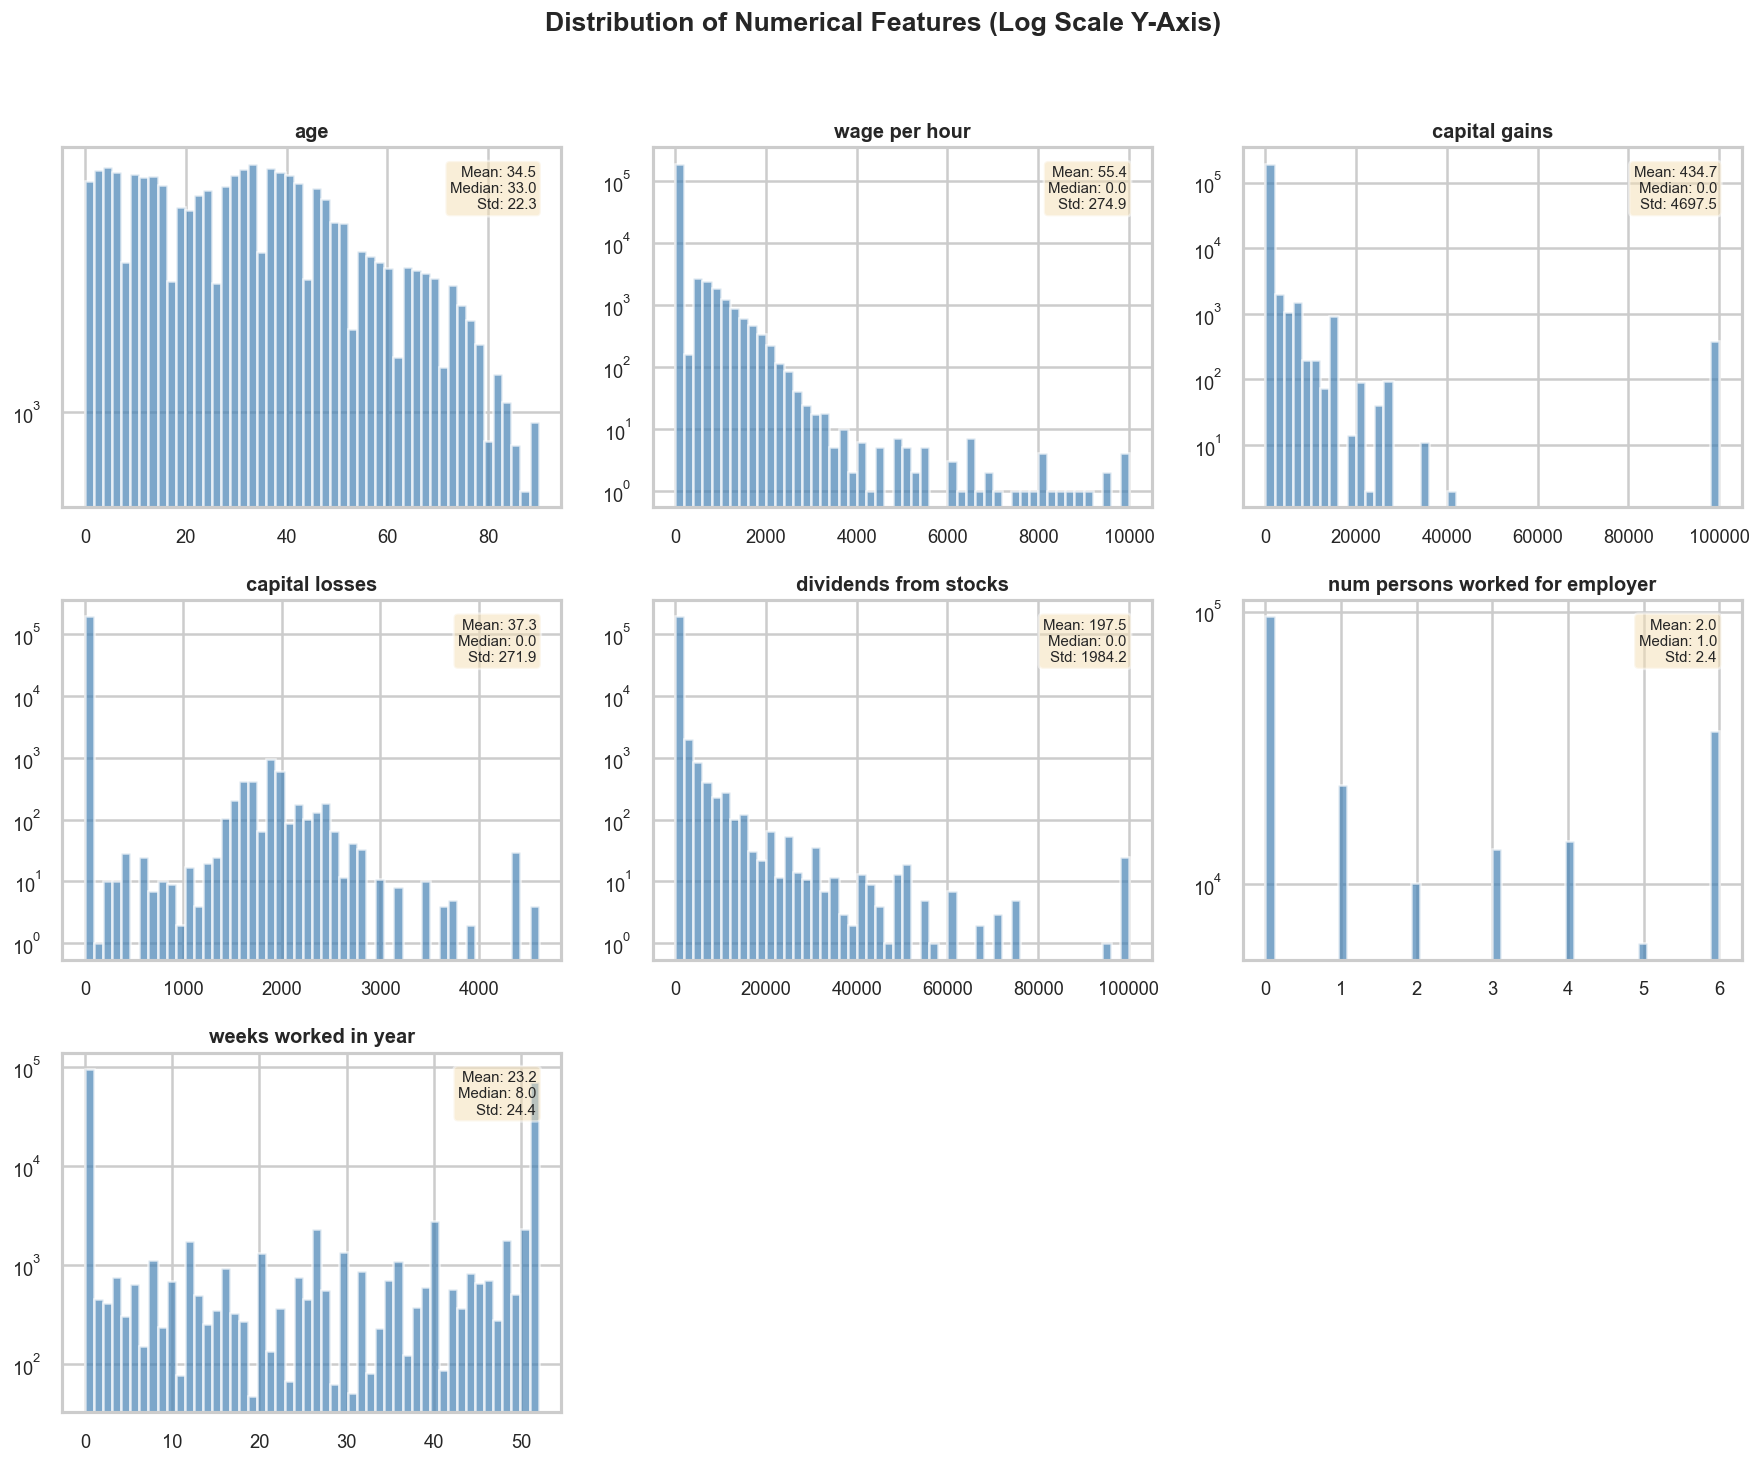

In [13]:
# Distribution of numerical features (with log scale)
n_features = len(NUMERICAL_FEATURES)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMERICAL_FEATURES):
    ax = axes[i]
    
    # Histogram
    df[col].hist(bins=50, ax=ax, color='steelblue', edgecolor='white', alpha=0.7)
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    
    # Log scale for y-axis to handle skewness
    ax.set_yscale('log')
    
    stats_text = f'Mean: {df[col].mean():.1f}\nMedian: {df[col].median():.1f}\nStd: {df[col].std():.1f}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribution of Numerical Features (Log Scale Y-Axis)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

NUMERICAL FEATURES BY INCOME CLASS


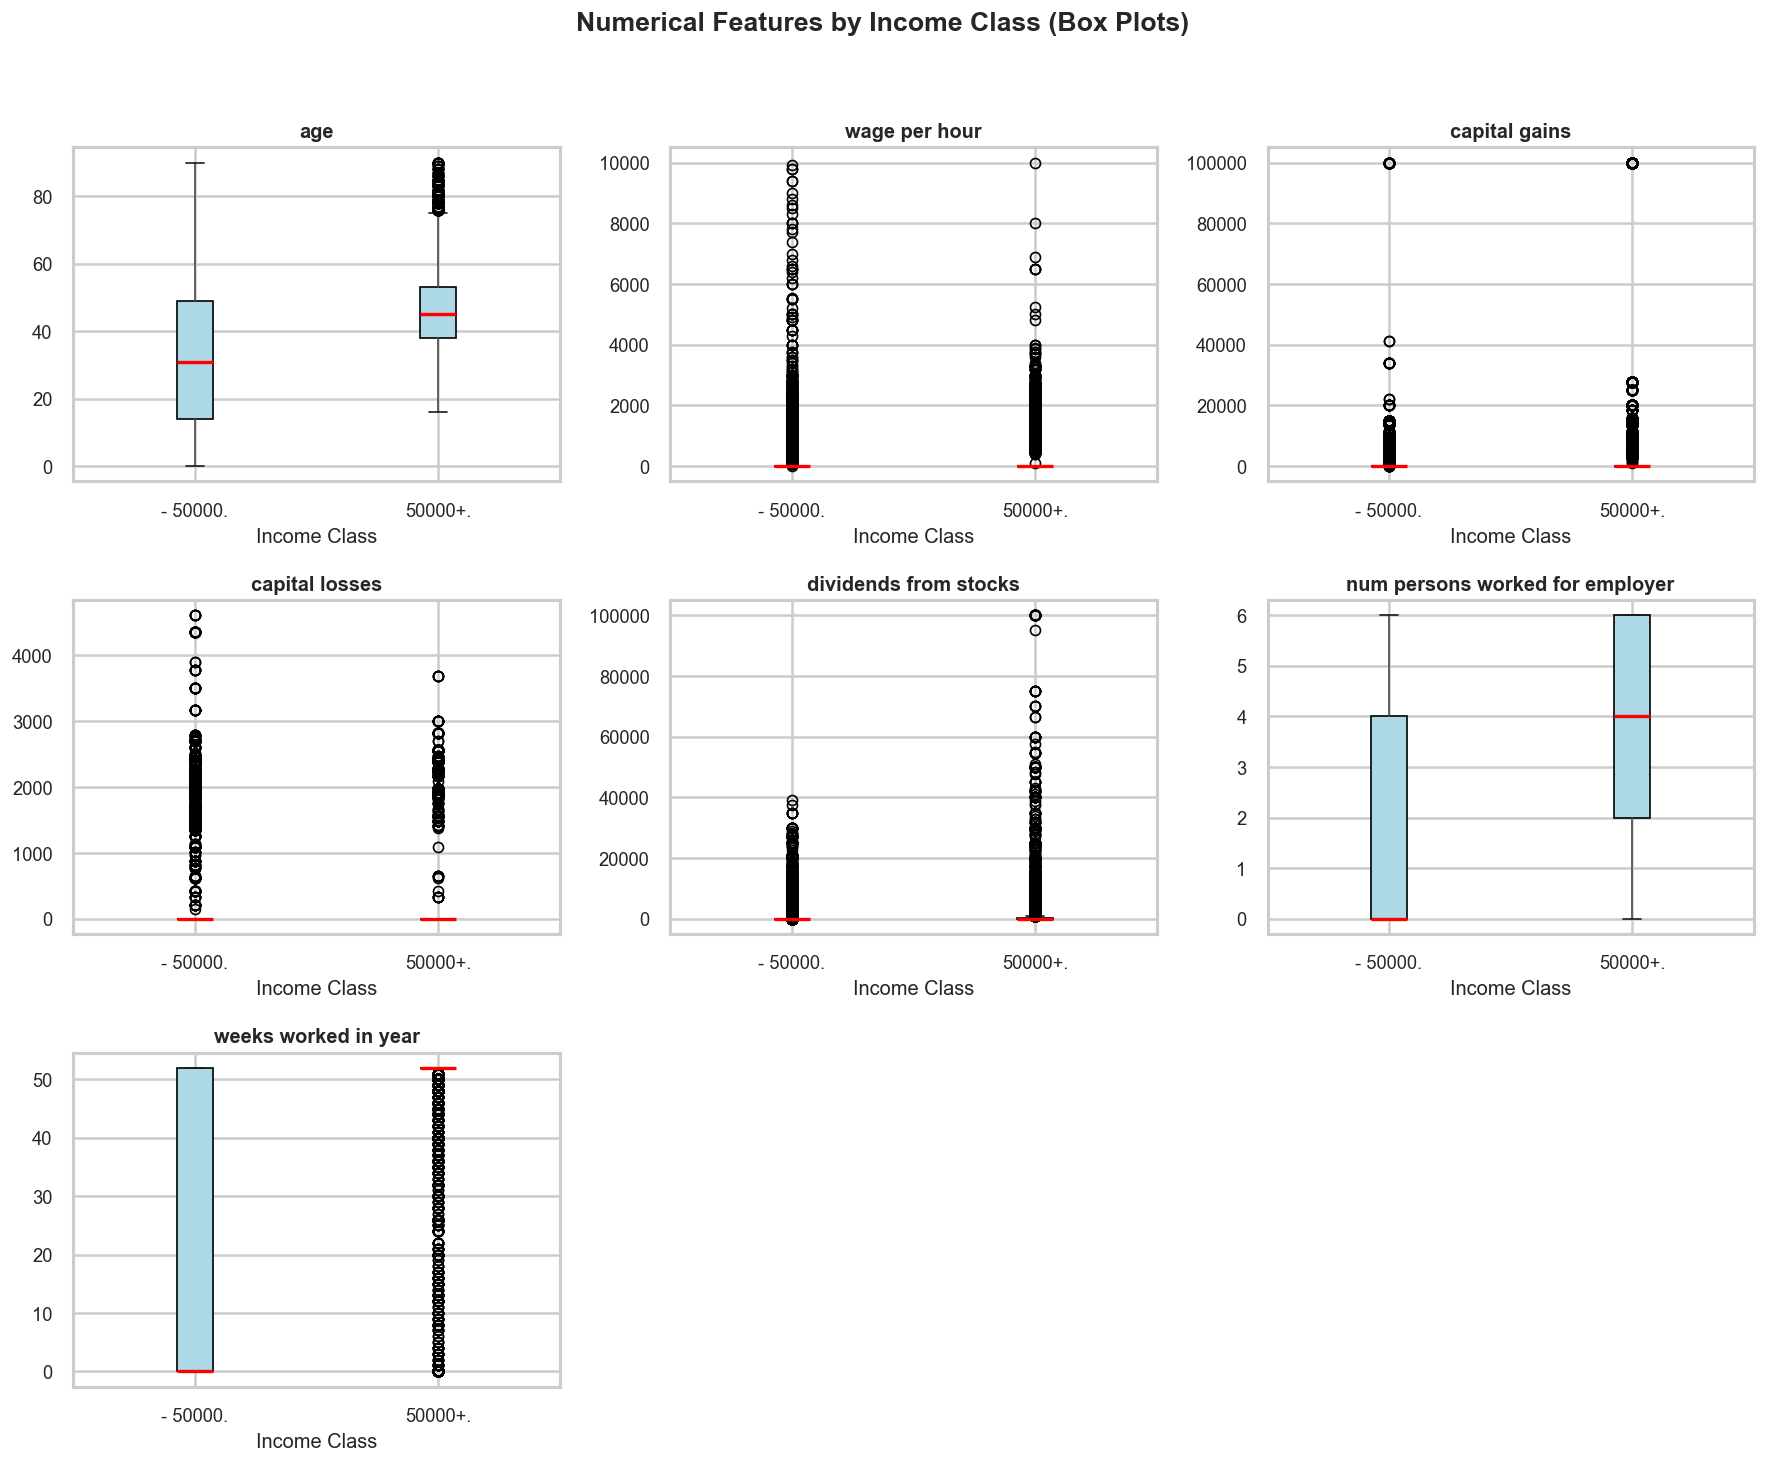

In [14]:
# Box plots comparing distributions by income class
print("NUMERICAL FEATURES BY INCOME CLASS")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(NUMERICAL_FEATURES):
    ax = axes[i]
    
    df.boxplot(column=col, by=TARGET, ax=ax, 
               patch_artist=True,
               boxprops=dict(facecolor='lightblue'),
               medianprops=dict(color='red', linewidth=2))
    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Income Class')
    ax.set_ylabel('')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Numerical Features by Income Class (Box Plots)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [15]:
# Key categorical features to analyze
key_categorical = ['education', 'class of worker', 'marital stat', 'sex', 'race', 
                   'major occupation code', 'major industry code']

print("KEY CATEGORICAL FEATURES - VALUE COUNTS")

for col in key_categorical:
    if col in df.columns:
        print(f"\n{col.upper()}:")
        print("-" * 50)
        vc = df[col].value_counts()
        vc_pct = df[col].value_counts(normalize=True) * 100
        
        for val, count in vc.items():
            pct = vc_pct[val]
            print(f"   {val}: {count:,} ({pct:.1f}%)")

KEY CATEGORICAL FEATURES - VALUE COUNTS

EDUCATION:
--------------------------------------------------
   High school graduate: 48,407 (24.3%)
   Children: 47,422 (23.8%)
   Some college but no degree: 27,820 (13.9%)
   Bachelors degree(BA AB BS): 19,865 (10.0%)
   7th and 8th grade: 8,007 (4.0%)
   10th grade: 7,557 (3.8%)
   11th grade: 6,876 (3.4%)
   Masters degree(MA MS MEng MEd MSW MBA): 6,541 (3.3%)
   9th grade: 6,230 (3.1%)
   Associates degree-occup /vocational: 5,358 (2.7%)
   Associates degree-academic program: 4,363 (2.2%)
   5th or 6th grade: 3,277 (1.6%)
   12th grade no diploma: 2,126 (1.1%)
   1st 2nd 3rd or 4th grade: 1,799 (0.9%)
   Prof school degree (MD DDS DVM LLB JD): 1,793 (0.9%)
   Doctorate degree(PhD EdD): 1,263 (0.6%)
   Less than 1st grade: 819 (0.4%)

CLASS OF WORKER:
--------------------------------------------------
   Not in universe: 100,245 (50.2%)
   Private: 72,028 (36.1%)
   Self-employed-not incorporated: 8,445 (4.2%)
   Local government: 7,784 (3

In [16]:
# Income distribution across key categorical features
print("INCOME DISTRIBUTION BY CATEGORICAL FEATURES")


key_cats = ['education', 'sex', 'race', 'class of worker', 'marital stat']

for col in key_cats:
    if col in df.columns:
        print(f"\n{col.upper()} vs INCOME:")
        print("-" * 60)
        
        ct = pd.crosstab(df[col], df[TARGET], normalize='index') * 100
        ct = ct.round(1)
        ct['Total Count'] = df[col].value_counts()
        ct = ct.sort_values(by=ct.columns[1] if len(ct.columns) > 1 else ct.columns[0], ascending=False)
        print(ct.to_string())

INCOME DISTRIBUTION BY CATEGORICAL FEATURES

EDUCATION vs INCOME:
------------------------------------------------------------
label                                   - 50000.  50000+.  Total Count
education                                                             
Prof school degree (MD DDS DVM LLB JD)      46.0     54.0         1793
Doctorate degree(PhD EdD)                   48.0     52.0         1263
Masters degree(MA MS MEng MEd MSW MBA)      68.8     31.2         6541
Bachelors degree(BA AB BS)                  80.3     19.7        19865
Associates degree-academic program          90.6      9.4         4363
Associates degree-occup /vocational         92.3      7.7         5358
Some college but no degree                  93.6      6.4        27820
High school graduate                        96.1      3.9        48407
12th grade no diploma                       98.4      1.6         2126
11th grade                                  99.0      1.0         6876
7th and 8th grade    

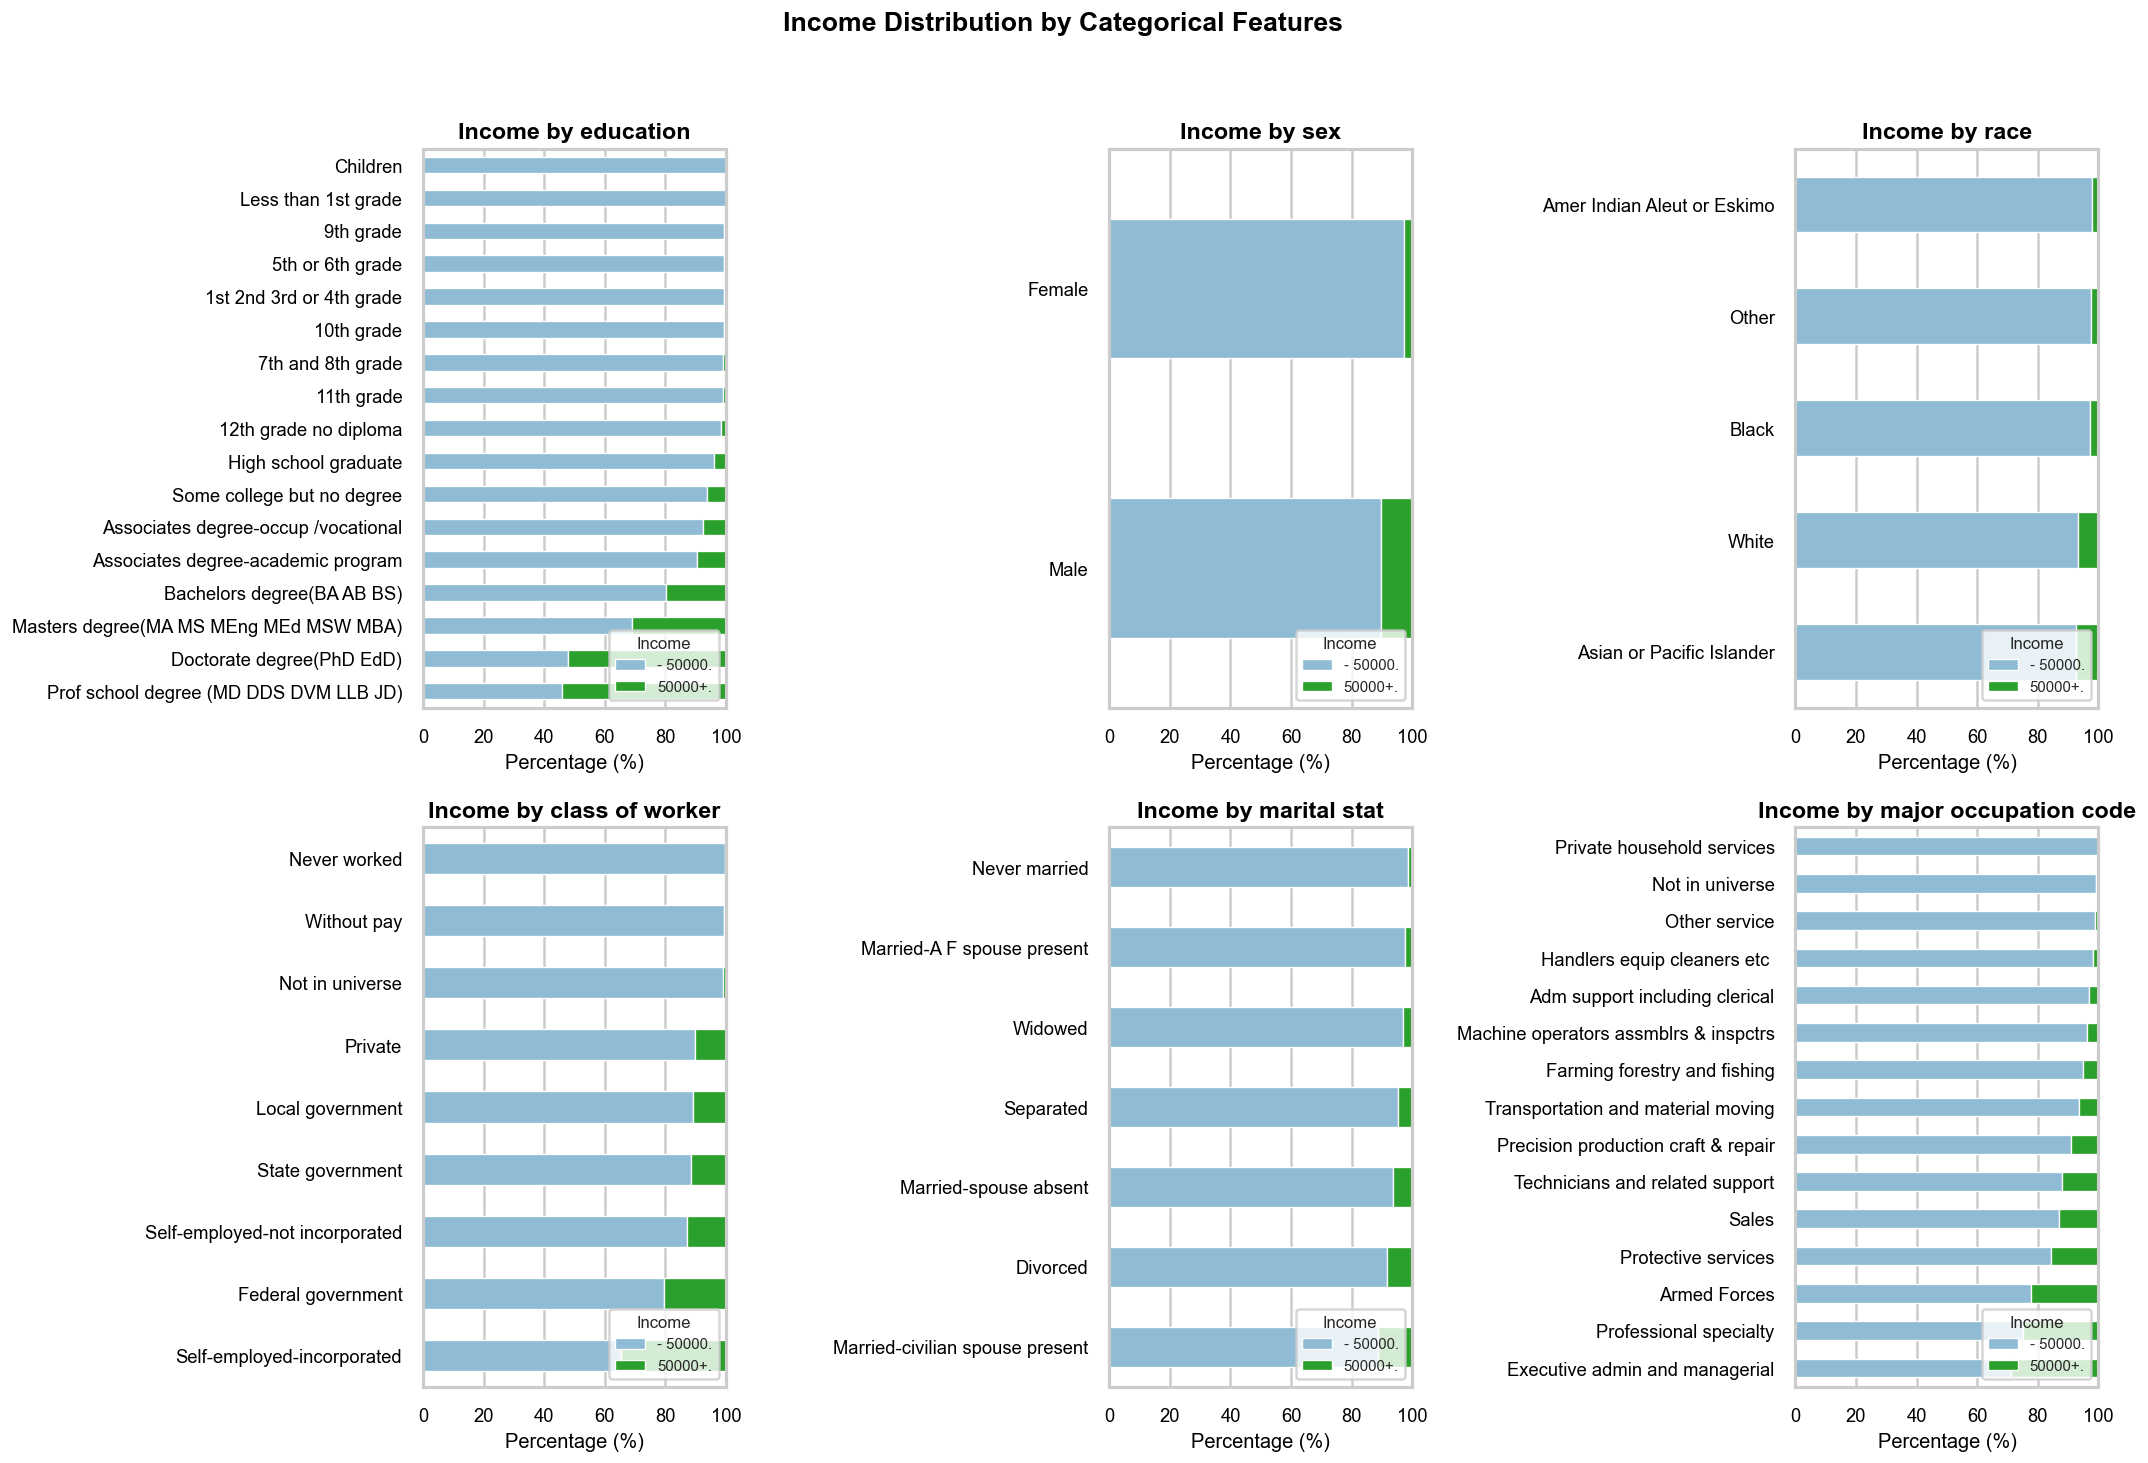

In [17]:
# Income by Categorical Features

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

plot_cats = [
    'education',
    'sex',
    'race',
    'class of worker',
    'marital stat',
    'major occupation code'
]

baseline_color = "#8fbcd4"   
positive_color = "#2ca02c"   
colors = [baseline_color, positive_color]

text_color = "#000000"

for i, col in enumerate(plot_cats):
    if col in df.columns:
        ax = axes[i]

        ct = pd.crosstab(df[col], df[TARGET], normalize="index") * 100

        high_income_col = [c for c in ct.columns if "50000" in str(c)]
        if high_income_col:
            ct = ct.sort_values(by=high_income_col[0], ascending=True)

        ct.plot(
            kind="barh",
            stacked=True,
            ax=ax,
            color=colors,
            edgecolor="white",
            linewidth=0.8
        )

        ax.set_title(f"Income by {col}", fontweight="bold", color=text_color)
        ax.set_xlabel("Percentage (%)", color=text_color)
        ax.set_ylabel("")
        ax.set_xlim(0, 100)

        ax.tick_params(colors=text_color)

        ax.legend(
            title="Income",
            loc="lower right",
            fontsize=9,
            title_fontsize=10,
            frameon=True
        )

plt.suptitle(
    "Income Distribution by Categorical Features",
    fontsize=16,
    fontweight="bold",
    color=text_color,
    y=1.02
)

plt.tight_layout()
plt.show()


AGE ANALYSIS


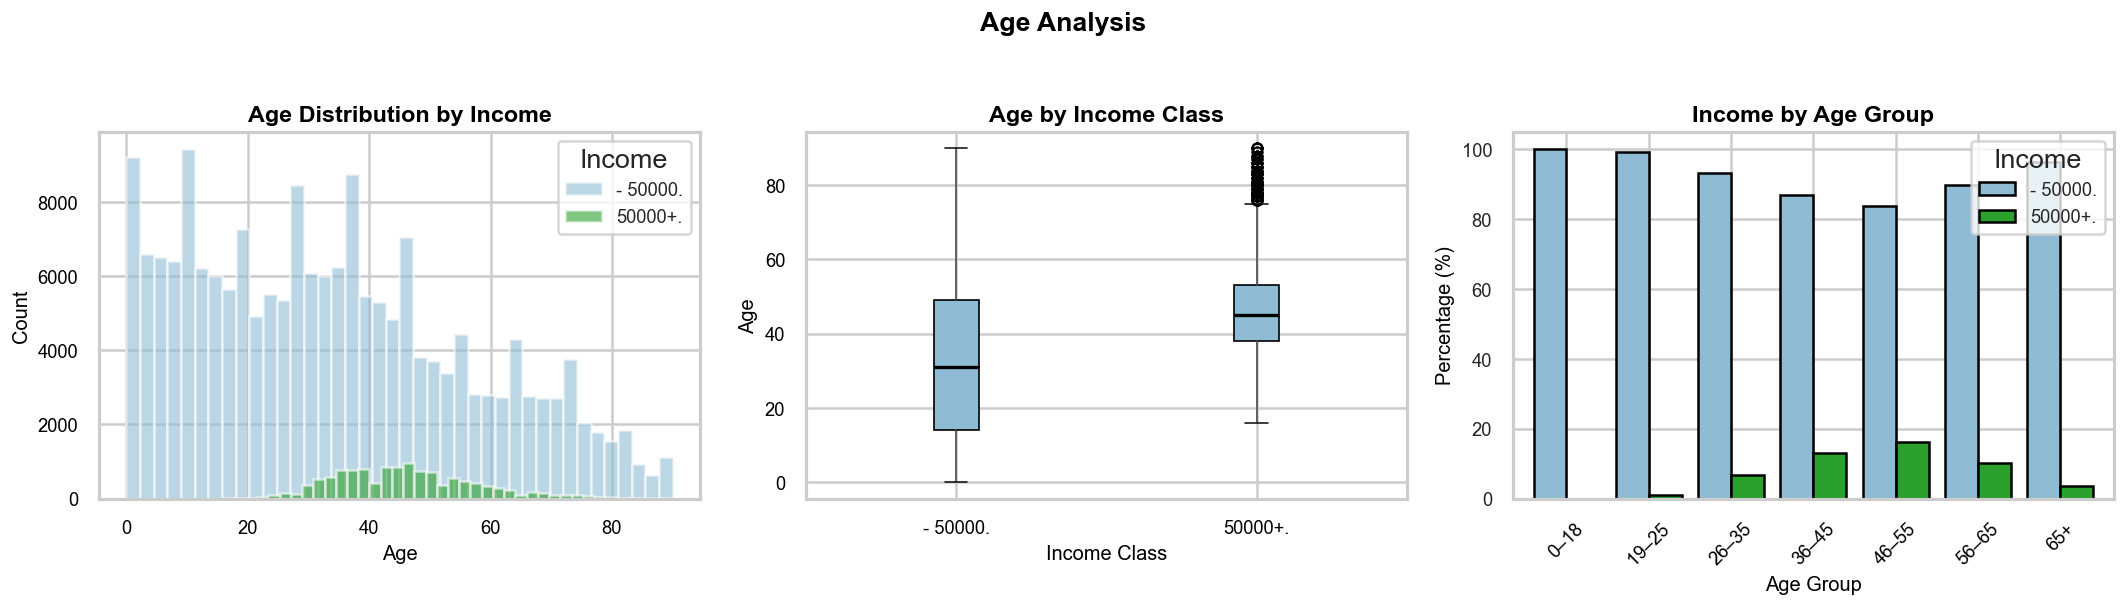

In [18]:
# Age Analysis
print("AGE ANALYSIS")

baseline_color = "#8fbcd4"   
positive_color = "#2ca02c"   
text_color = "#000000"

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram by income class 
for label, color in zip(df[TARGET].unique(), [baseline_color, positive_color]):
    df[df[TARGET] == label]['age'].plot(
        kind="hist",
        bins=40,
        ax=axes[0],
        alpha=0.6,
        label=str(label),
        color=color,
        edgecolor="white"
    )

axes[0].set_title("Age Distribution by Income", fontweight="bold", color=text_color)
axes[0].set_xlabel("Age", color=text_color)
axes[0].set_ylabel("Count", color=text_color)
axes[0].tick_params(colors=text_color)
axes[0].legend(title="Income")

# Box plot
df.boxplot(
    column="age",
    by=TARGET,
    ax=axes[1],
    patch_artist=True,
    boxprops=dict(facecolor=baseline_color, edgecolor=text_color),
    medianprops=dict(color=text_color, linewidth=2)
)

axes[1].set_title("Age by Income Class", fontweight="bold", color=text_color)
axes[1].set_xlabel("Income Class", color=text_color)
axes[1].set_ylabel("Age", color=text_color)
axes[1].tick_params(colors=text_color)

axes[1].get_figure().suptitle("")

# Age groups
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 18, 25, 35, 45, 55, 65, 100],
    labels=["0–18", "19–25", "26–35", "36–45", "46–55", "56–65", "65+"]
)

ct = pd.crosstab(df["age_group"], df[TARGET], normalize="index") * 100

ct.plot(
    kind="bar",
    ax=axes[2],
    color=[baseline_color, positive_color],
    edgecolor="black",
    width=0.8
)

axes[2].set_title("Income by Age Group", fontweight="bold", color=text_color)
axes[2].set_xlabel("Age Group", color=text_color)
axes[2].set_ylabel("Percentage (%)", color=text_color)
axes[2].tick_params(axis="x", rotation=45, colors=text_color)
axes[2].legend(title="Income")

plt.suptitle("Age Analysis", fontsize=16, fontweight="bold", color=text_color, y=1.02)
plt.tight_layout()
plt.show()

df.drop("age_group", axis=1, inplace=True)


CORRELATION ANALYSIS


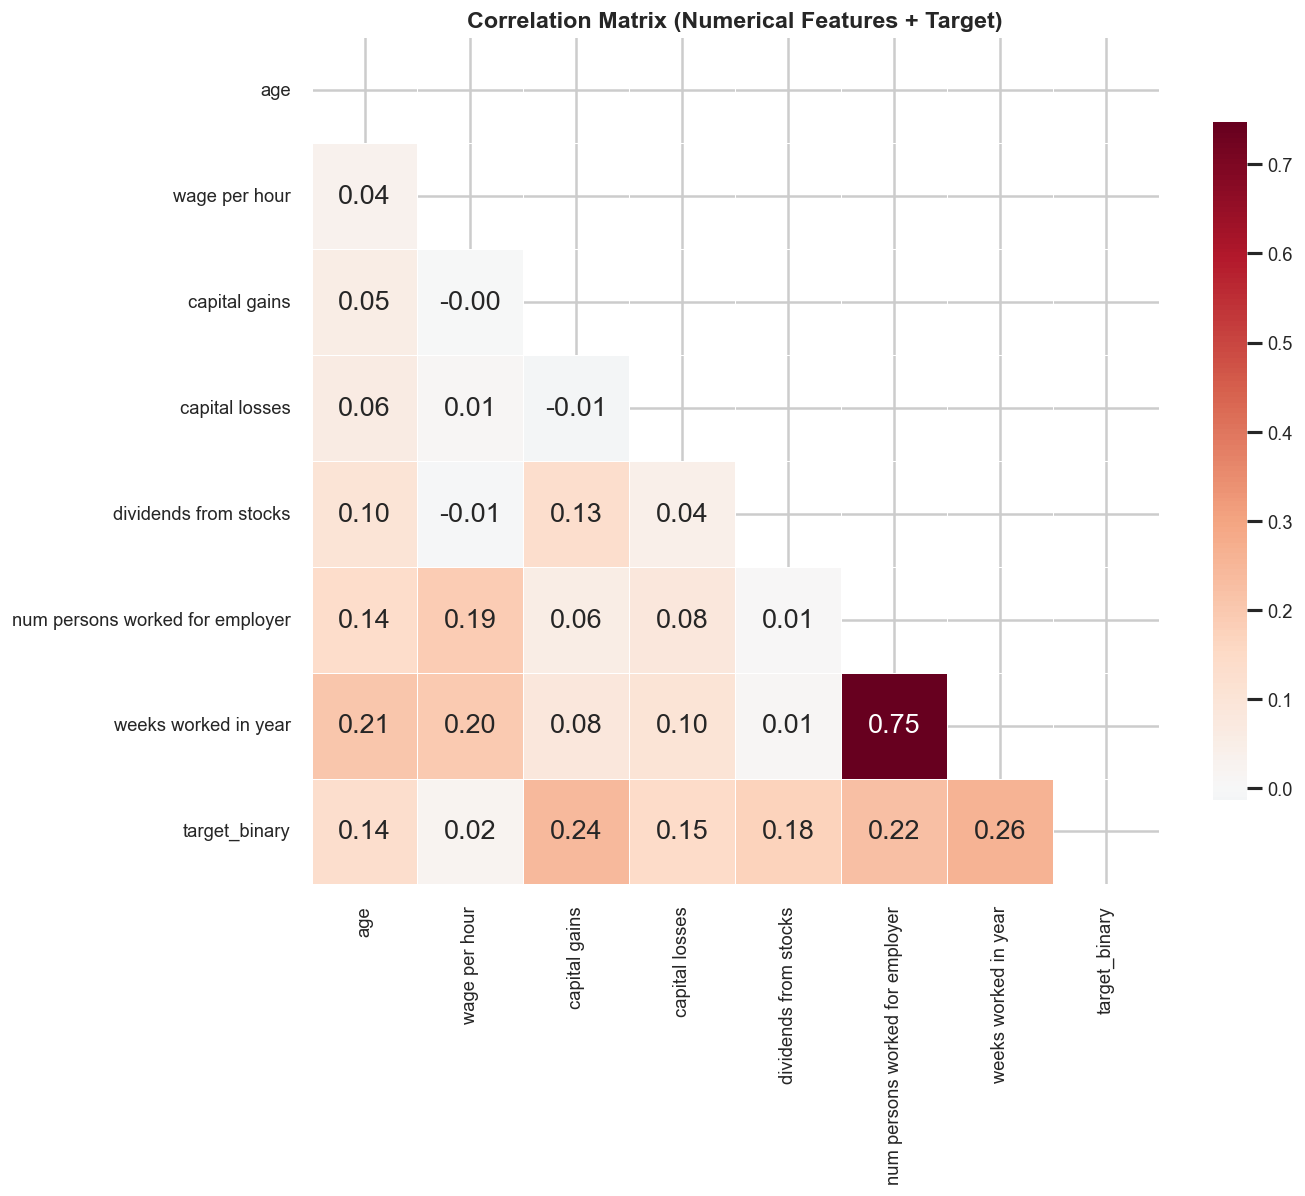


Correlation with Target (Income >50K):
--------------------------------------------------
   weeks worked in year: 0.2623
   capital gains: 0.2407
   num persons worked for employer: 0.2227
   dividends from stocks: 0.1758
   capital losses: 0.1474
   age: 0.1357
   wage per hour: 0.0245


In [19]:
# Correlation analysis
print("CORRELATION ANALYSIS")

df['target_binary'] = (df[TARGET].str.contains('50000') & ~df[TARGET].str.contains('-')).astype(int)

# Correlation matrix
corr_cols = NUMERICAL_FEATURES + ['target_binary']
corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Matrix (Numerical Features + Target)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation with target
print("\nCorrelation with Target (Income >50K):")
print("-" * 50)
target_corr = corr_matrix['target_binary'].drop('target_binary').sort_values(ascending=False)
for feat, corr in target_corr.items():
    print(f"   {feat}: {corr:.4f}")

# Clean up
df.drop('target_binary', axis=1, inplace=True)

CATEGORICAL FEATURES - ASSOCIATION WITH TARGET (Cramer's V)

Cramer's V interpretation: 0.1=weak, 0.3=moderate, 0.5=strong

                                   Feature  Cramers_V
                detailed occupation recode   0.438209
                                 education   0.389837
                     major occupation code   0.366264
                  detailed industry recode   0.292957
                       major industry code   0.277860
                           class of worker   0.260531
        detailed household and family stat   0.240458
                            tax filer stat   0.229232
   detailed household summary in household   0.227220
                              marital stat   0.197655
         full or part time employment stat   0.159847
                   family members under 18   0.159167
                                       sex   0.157589
                         veterans benefits   0.144339
             own business or self employed   0.083900
            

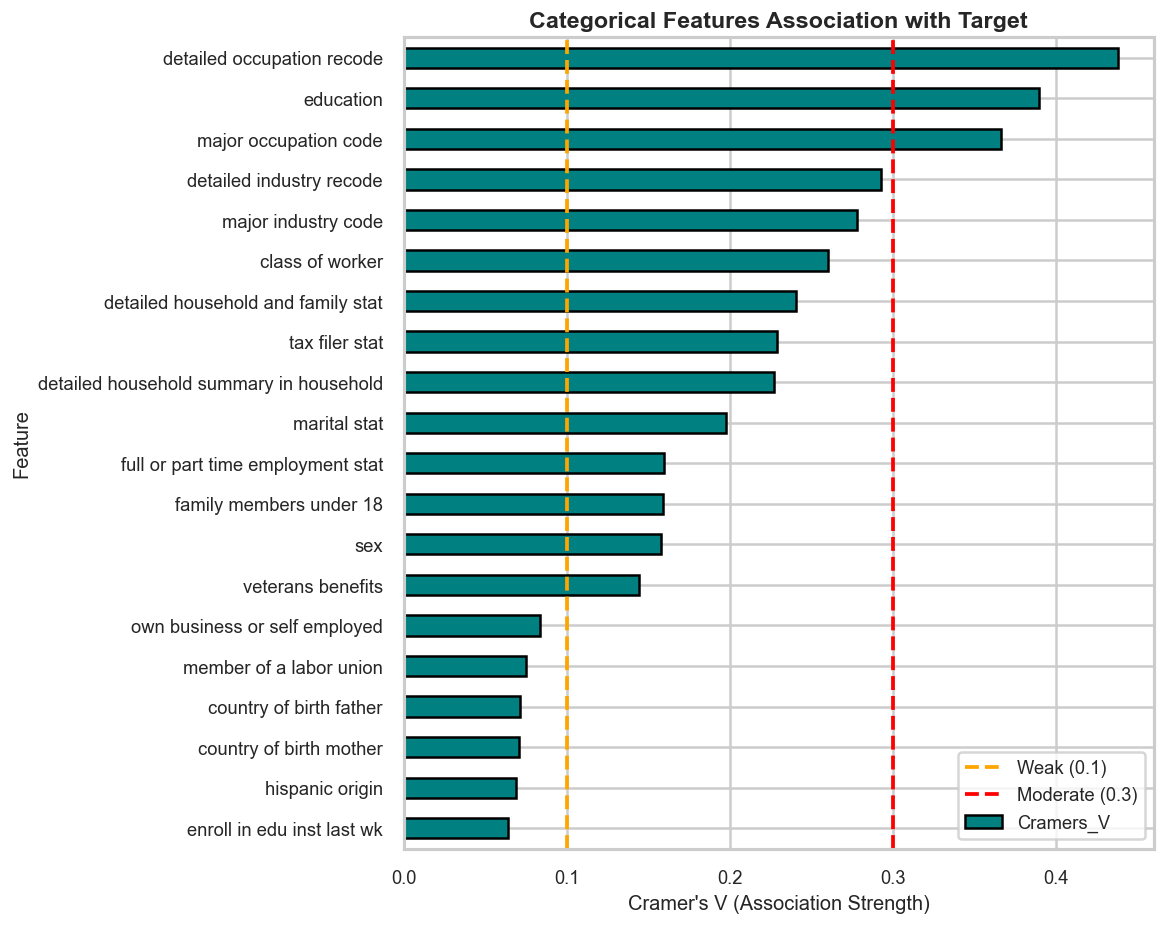


TOP CATEGORICAL PREDICTORS:
--------------------------------------------------
   detailed occupation recode: 0.4382 (Strong)
   education: 0.3898 (Strong)
   major occupation code: 0.3663 (Strong)
   detailed industry recode: 0.2930 (Moderate)
   major industry code: 0.2779 (Moderate)
   class of worker: 0.2605 (Moderate)
   detailed household and family stat: 0.2405 (Moderate)
   tax filer stat: 0.2292 (Moderate)
   detailed household summary in household: 0.2272 (Moderate)
   marital stat: 0.1977 (Moderate)


In [20]:
# Categorical Features Correlation with Target (Cramer's V)
def cramers_v(x, y):
    """Calculate Cramer's V statistic for categorical-categorical association"""
    contingency = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency)[0]
    n = len(x)
    min_dim = min(contingency.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0


print("CATEGORICAL FEATURES - ASSOCIATION WITH TARGET (Cramer's V)")

print("\nCramer's V interpretation: 0.1=weak, 0.3=moderate, 0.5=strong\n")

# Calculate Cramer's V for each categorical feature
cramers_results = {}
for col in CATEGORICAL_FEATURES:
    if col in df.columns:
        try:
            v = cramers_v(df[col], df[TARGET])
            cramers_results[col] = v
        except:
            cramers_results[col] = np.nan

# Sort by association strength
cramers_df = pd.DataFrame({
    'Feature': cramers_results.keys(),
    'Cramers_V': cramers_results.values()
}).sort_values('Cramers_V', ascending=False).reset_index(drop=True)

print(cramers_df.to_string(index=False))

# Visualize top features
fig, ax = plt.subplots(figsize=(10, 8))
top_n = min(20, len(cramers_df))
cramers_df.head(top_n).plot(kind='barh', x='Feature', y='Cramers_V', ax=ax, 
                             color='teal', edgecolor='black', legend=False)
ax.set_xlabel("Cramer's V (Association Strength)")
ax.set_title('Categorical Features Association with Target', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.axvline(x=0.1, color='orange', linestyle='--', label='Weak (0.1)')
ax.axvline(x=0.3, color='red', linestyle='--', label='Moderate (0.3)')
ax.legend()
plt.tight_layout()
plt.show()

print("\nTOP CATEGORICAL PREDICTORS:")
print("-" * 50)
for _, row in cramers_df.head(10).iterrows():
    strength = "Strong" if row['Cramers_V'] >= 0.3 else "Moderate" if row['Cramers_V'] >= 0.1 else "Weak"
    feat_name = row['Feature']
    v_score = row['Cramers_V']
    print(f"   {feat_name}: {v_score:.4f} ({strength})")

CATEGORICAL FEATURES - INTER-CORRELATION MATRIX (Cramer's V)


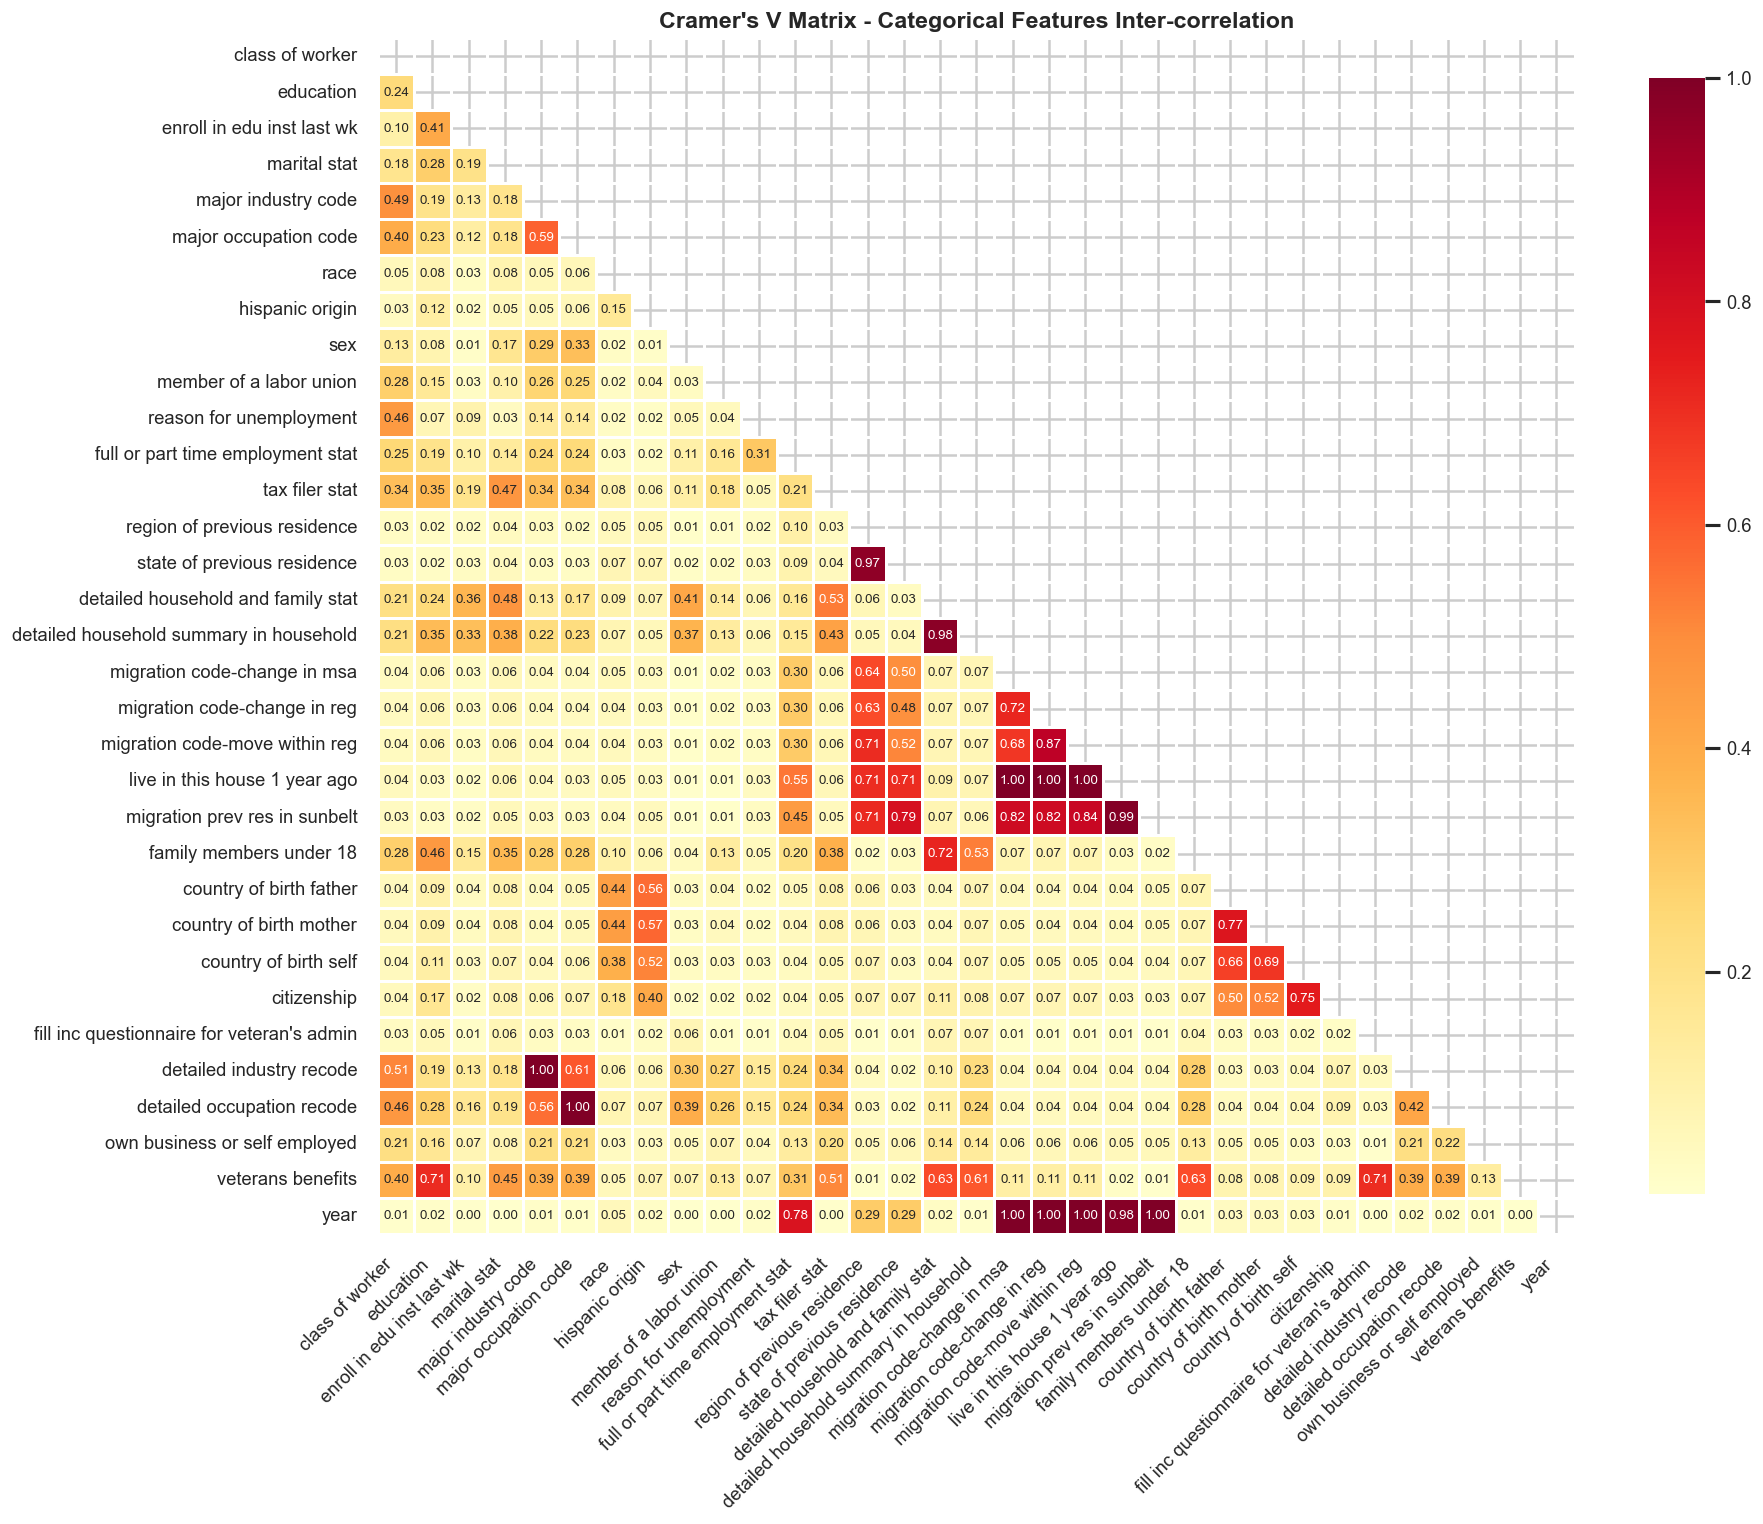


HIGHLY CORRELATED CATEGORICAL PAIRS

Found 51 pairs with Cramer's V >= 0.5:

                                 Feature_1                               Feature_2  Cramers_V Strength
            migration code-move within reg                                    year   1.000000   Strong
              migration code-change in reg                                    year   1.000000   Strong
                       major industry code                detailed industry recode   1.000000   Strong
            migration code-move within reg           live in this house 1 year ago   1.000000   Strong
                     major occupation code              detailed occupation recode   1.000000   Strong
              migration code-change in reg           live in this house 1 year ago   1.000000   Strong
             migration prev res in sunbelt                                    year   1.000000   Strong
              migration code-change in msa                                    year   1.000000   St

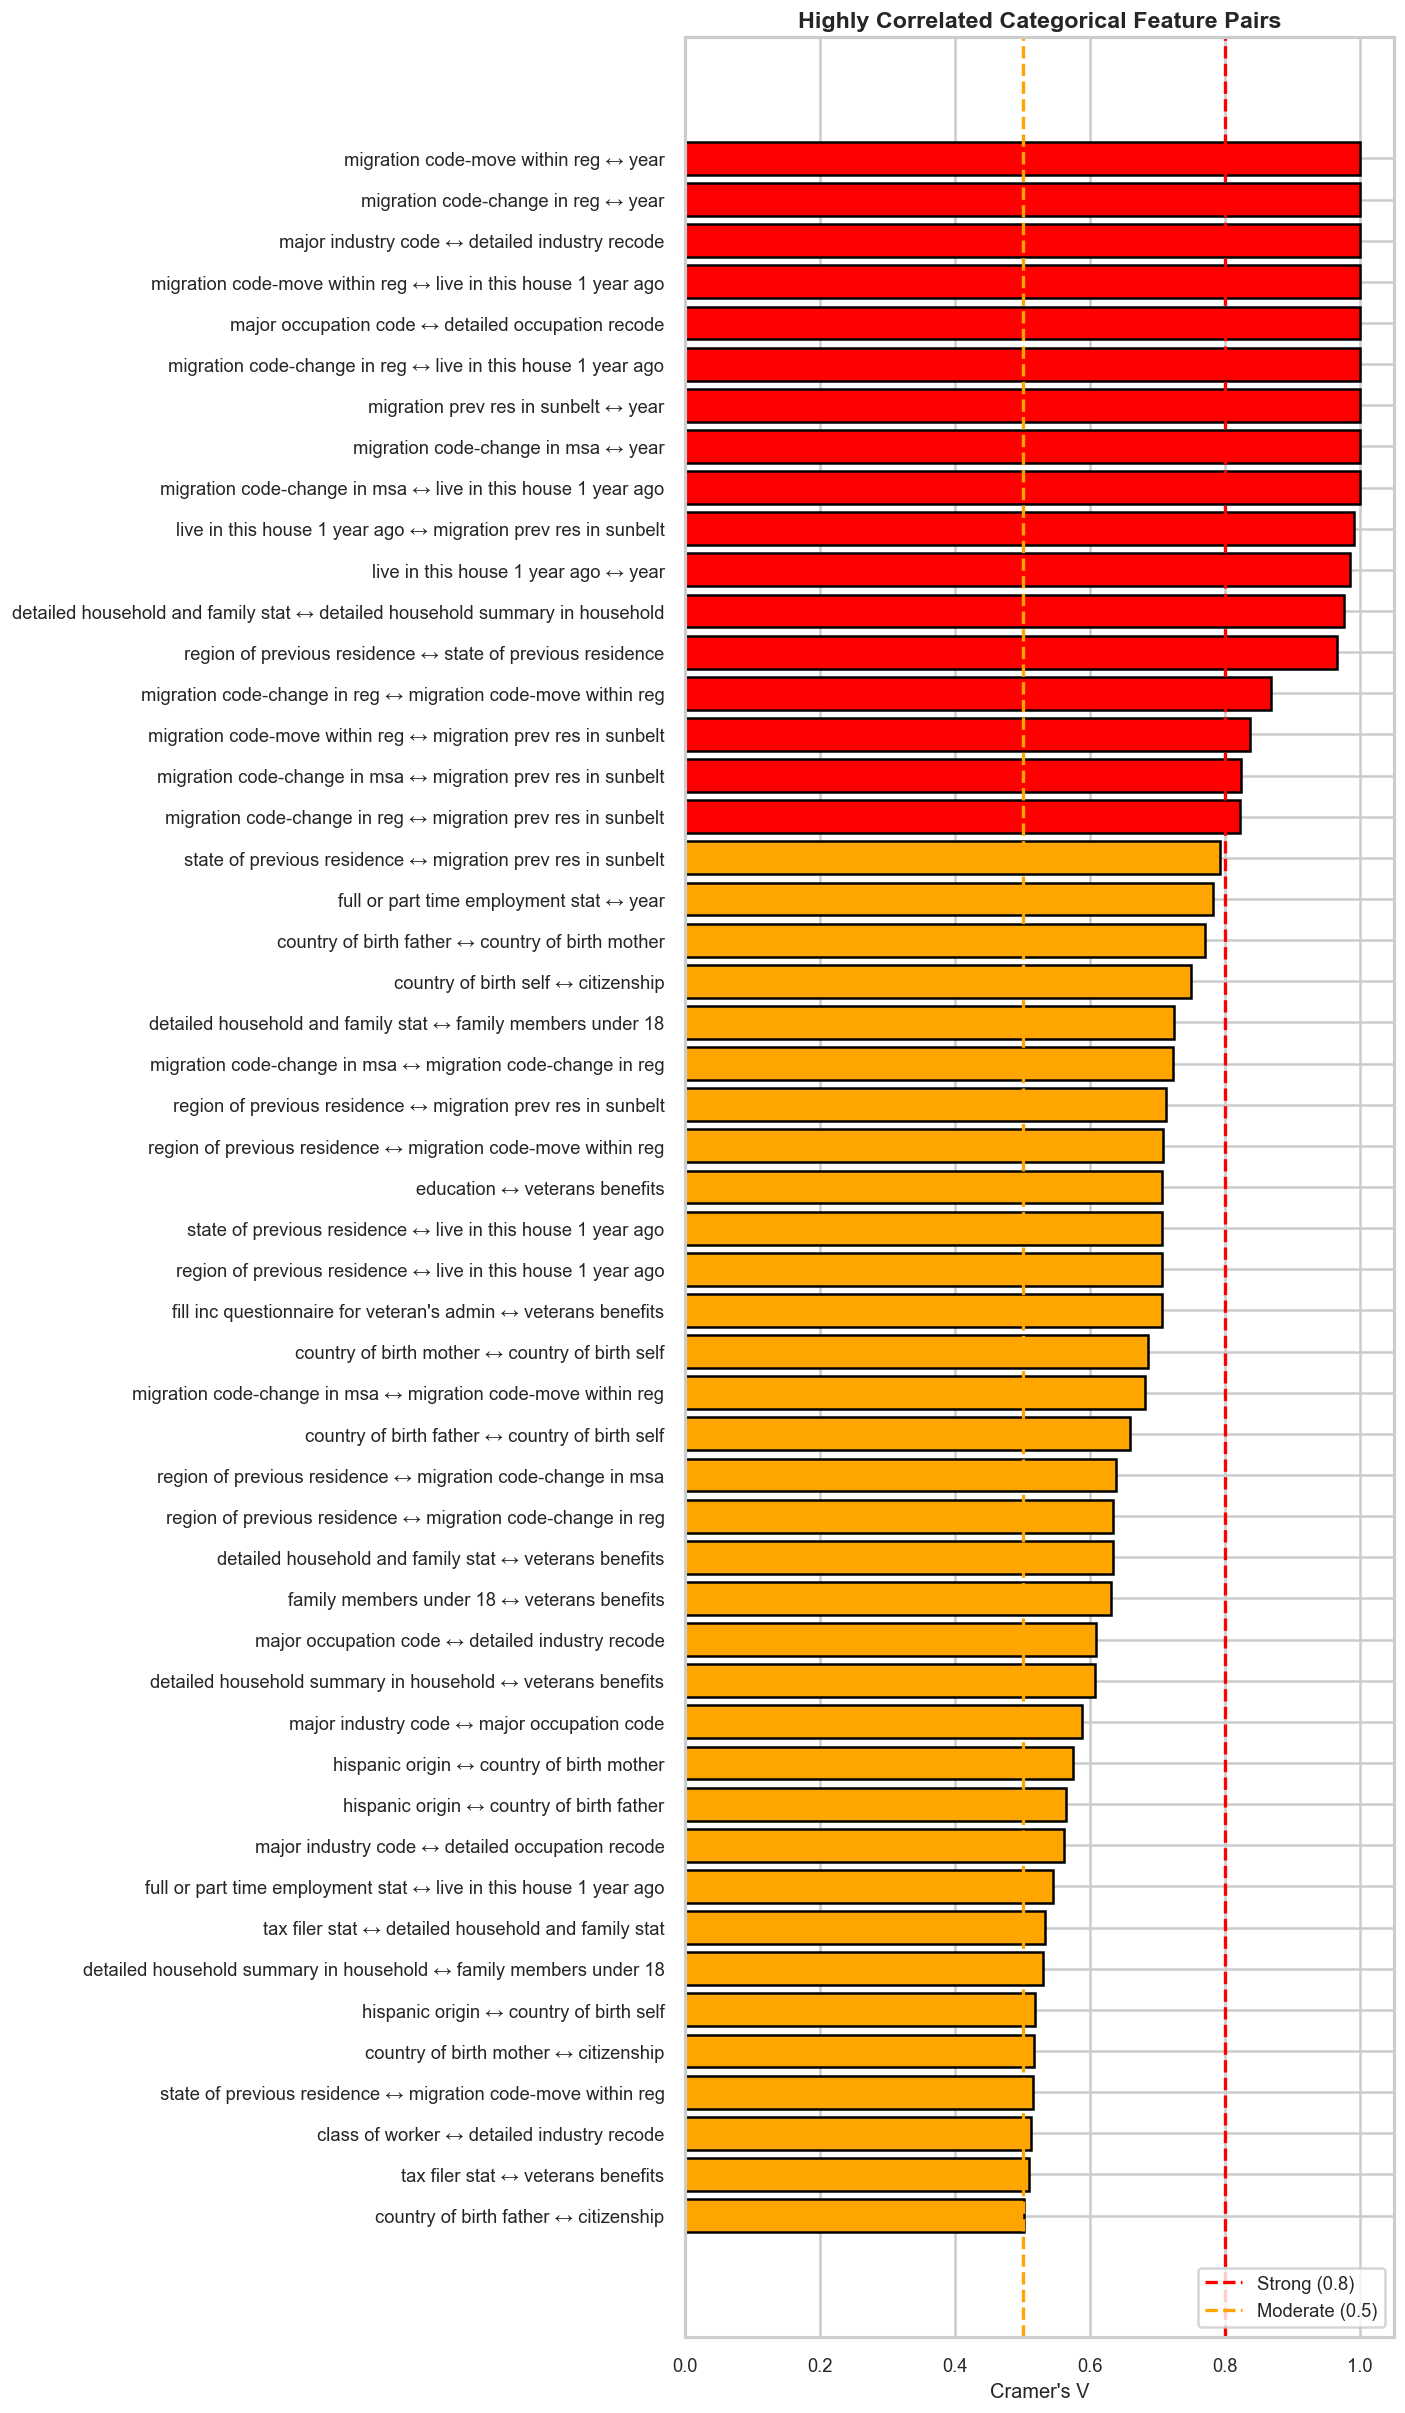

In [21]:
# Categorical-Categorical Correlation Matrix (Cramer's V)
def cramers_v(x, y):
    """Calculate Cramer's V statistic for categorical-categorical association"""
    contingency = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency)[0]
    n = len(x)
    min_dim = min(contingency.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

print("CATEGORICAL FEATURES - INTER-CORRELATION MATRIX (Cramer's V)")

cat_cols = [col for col in CATEGORICAL_FEATURES if col in df.columns]

cramers_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        else:
            cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramers_matrix = cramers_matrix.astype(float)

fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(cramers_matrix, dtype=bool))
sns.heatmap(cramers_matrix, mask=mask, annot=True, fmt='.2f', cmap='YlOrRd',
            ax=ax, square=True, linewidths=0.8, cbar_kws={'shrink': 0.8},
            annot_kws={'size': 8})
ax.set_title("Cramer's V Matrix - Categorical Features Inter-correlation", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("HIGHLY CORRELATED CATEGORICAL PAIRS")


threshold_strong = 0.8
threshold_moderate = 0.5

high_corr_pairs = []
for col1, col2 in combinations(cat_cols, 2):
    v = cramers_matrix.loc[col1, col2]
    if v >= threshold_moderate:
        high_corr_pairs.append({
            'Feature_1': col1,
            'Feature_2': col2,
            'Cramers_V': v,
            'Strength': 'Strong' if v >= threshold_strong else 'Moderate'
        })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Cramers_V', ascending=False)

if len(high_corr_df) > 0:
    print(f"\nFound {len(high_corr_df)} pairs with Cramer's V >= {threshold_moderate}:\n")
    print(high_corr_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("FEATURE DROPPING")
      
    feature_counts = {}
    for _, row in high_corr_df.iterrows():
        for feat in [row['Feature_1'], row['Feature_2']]:
            feature_counts[feat] = feature_counts.get(feat, 0) + 1
    
    feature_freq = pd.DataFrame({
        'Feature': feature_counts.keys(),
        'Times_in_High_Corr_Pairs': feature_counts.values()
    }).sort_values('Times_in_High_Corr_Pairs', ascending=False)
    
    print("\nFeatures appearing most often in correlated pairs:")
    print(feature_freq.to_string(index=False))
    
    print("\n\nPairs with V >= 0.8):")
    print("-" * 60)
    strong_pairs = high_corr_df[high_corr_df['Strength'] == 'Strong']
    if len(strong_pairs) > 0:
        for _, row in strong_pairs.iterrows():
            f1, f2, v = row['Feature_1'], row['Feature_2'], row['Cramers_V']
            nunique_1 = df[f1].nunique()
            nunique_2 = df[f2].nunique()
            drop_suggestion = f1 if nunique_1 > nunique_2 else f2
            keep_suggestion = f2 if nunique_1 > nunique_2 else f1
            print(f"• {f1} <-> {f2} (V={v:.3f})")
            print(f"  -> Consider dropping '{drop_suggestion}' (more categories: {max(nunique_1, nunique_2)})")
            print(f"  -> Keep '{keep_suggestion}' (fewer categories: {min(nunique_1, nunique_2)})\n")
    else:
        print("No strongly correlated pairs (V >= 0.8) found.")
else:
    print(f"\nNo highly correlated pairs found with Cramer's V >= {threshold_moderate}")

# Visualize high correlation pairs
if len(high_corr_df) > 0:
    fig, ax = plt.subplots(figsize=(12, max(4, len(high_corr_df) * 0.4)))
    colors = ['red' if s == 'Strong' else 'orange' for s in high_corr_df['Strength']]
    pair_labels = [f"{row['Feature_1']} ↔ {row['Feature_2']}" for _, row in high_corr_df.iterrows()]
    
    bars = ax.barh(pair_labels, high_corr_df['Cramers_V'], color=colors, edgecolor='black')
    ax.set_xlabel("Cramer's V")
    ax.set_title('Highly Correlated Categorical Feature Pairs', fontsize=14, fontweight='bold')
    ax.axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='Strong (0.8)')
    ax.axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Moderate (0.5)')
    ax.legend(loc='lower right')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

EDUCATION DEEP DIVE


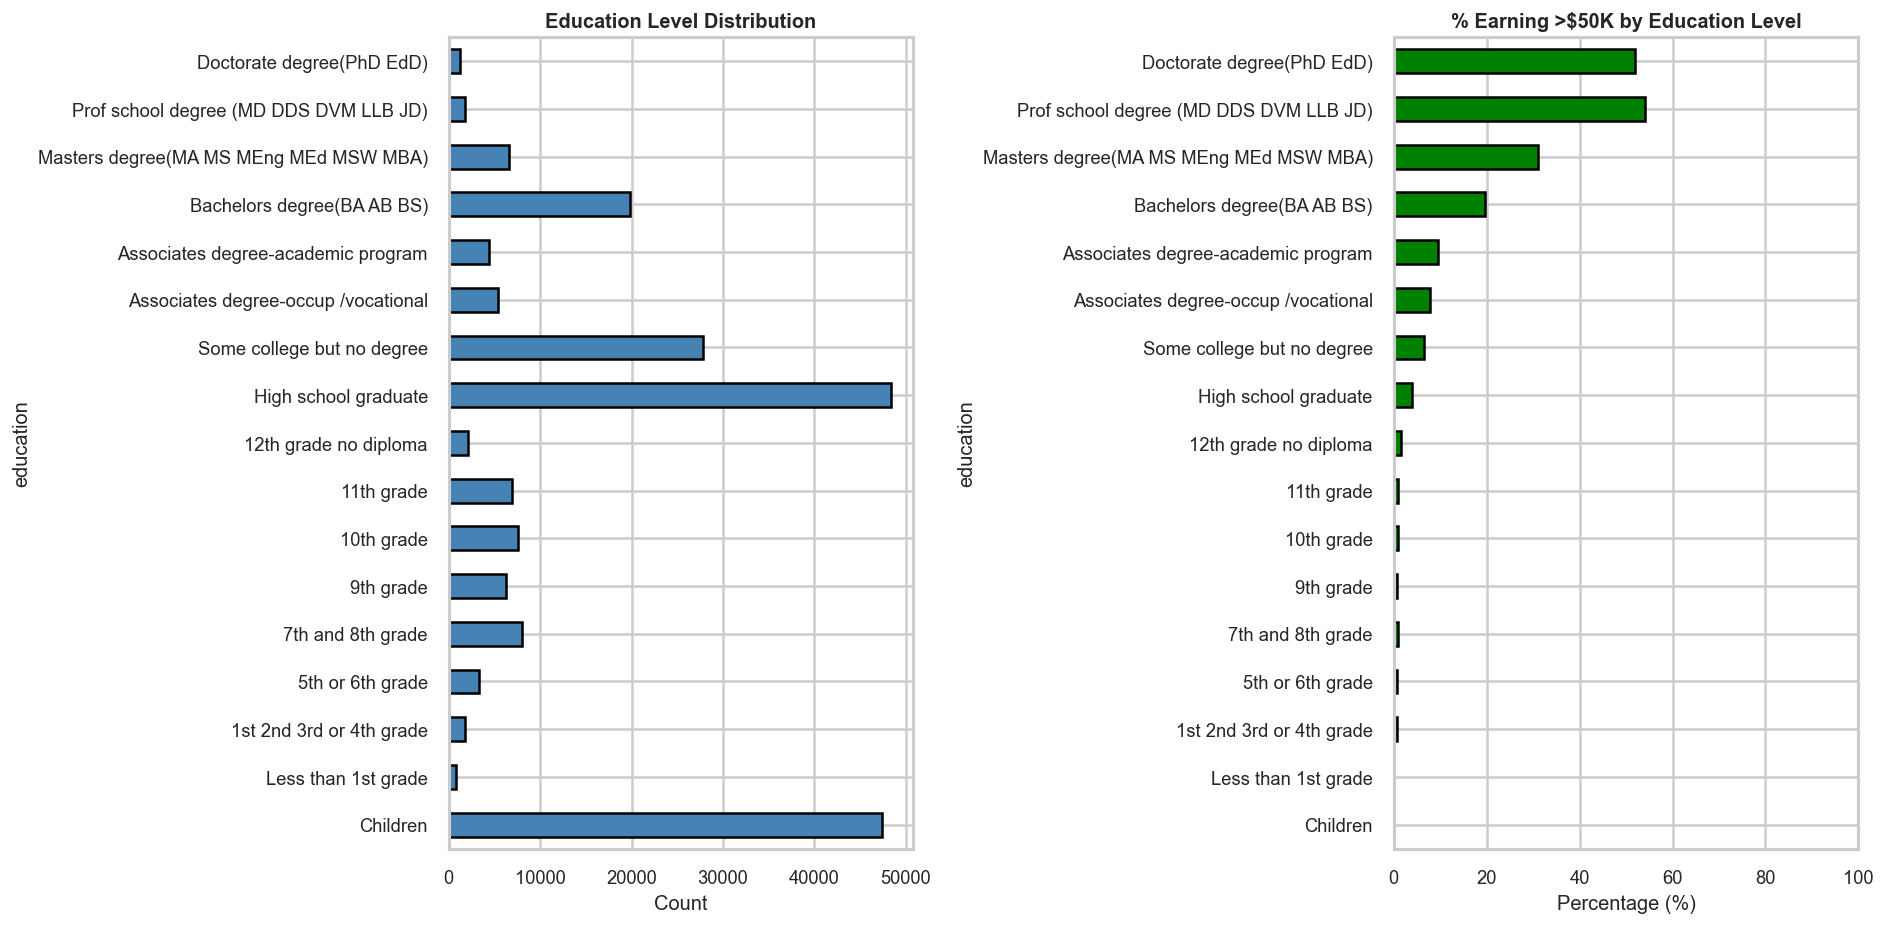

In [22]:
# Education analysis
print("EDUCATION DEEP DIVE")

# Education order
education_order = [
    'Children', 'Less than 1st grade', '1st 2nd 3rd or 4th grade',
    '5th or 6th grade', '7th and 8th grade', '9th grade', '10th grade',
    '11th grade', '12th grade no diploma', 'High school graduate',
    'Some college but no degree', 'Associates degree-occup /vocational',
    'Associates degree-academic program', 'Bachelors degree(BA AB BS)',
    'Masters degree(MA MS MEng MEd MSW MBA)', 'Prof school degree (MD DDS DVM LLB JD)',
    'Doctorate degree(PhD EdD)'
]

education_order = [e for e in education_order if e in df['education'].unique()]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

edu_counts = df['education'].value_counts().reindex(education_order)
edu_counts.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Education Level Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Count')

# Income by education
ct = pd.crosstab(df['education'], df[TARGET], normalize='index') * 100
ct = ct.reindex(education_order)
high_income_col = [c for c in ct.columns if '50000' in str(c) and '-' not in str(c)]
if high_income_col:
    ct[high_income_col[0]].plot(kind='barh', ax=axes[1], color='green', edgecolor='black')
    axes[1].set_title('% Earning >$50K by Education Level', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Percentage (%)')
    axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()

In [23]:
# Capital gains/losses analysis
print("CAPITAL GAINS & LOSSES ANALYSIS")

print("\nNon-zero Capital Gains:")
cg_nonzero = (df['capital gains'] > 0).sum()
print(f"   {cg_nonzero:,} records ({cg_nonzero/len(df)*100:.2f}%)")

print("\nNon-zero Capital Losses:")
cl_nonzero = (df['capital losses'] > 0).sum()
print(f"   {cl_nonzero:,} records ({cl_nonzero/len(df)*100:.2f}%)")

print("\nIncome distribution for people WITH capital gains:")
cg_subset = df[df['capital gains'] > 0]
print(cg_subset[TARGET].value_counts(normalize=True) * 100)

print("\nIncome distribution for people WITHOUT capital gains:")
no_cg_subset = df[df['capital gains'] == 0]
print(no_cg_subset[TARGET].value_counts(normalize=True) * 100)

CAPITAL GAINS & LOSSES ANALYSIS

Non-zero Capital Gains:
   7,379 records (3.70%)

Non-zero Capital Losses:
   3,906 records (1.96%)

Income distribution for people WITH capital gains:
label
- 50000.    67.312644
50000+.     32.687356
Name: proportion, dtype: float64

Income distribution for people WITHOUT capital gains:
label
- 50000.    94.811183
50000+.      5.188817
Name: proportion, dtype: float64


In [24]:
# Summary by income class
print("SUMMARY STATISTICS BY INCOME CLASS")

for label in df[TARGET].unique():
    print(f"\n{'='*60}")
    print(f"Income Class: {label}")
    print(f"{'='*60}")
    subset = df[df[TARGET] == label]
    print(f"Count: {len(subset):,}")
    print(f"\nNumerical Features Summary:")
    print(subset[NUMERICAL_FEATURES].describe().round(2))

SUMMARY STATISTICS BY INCOME CLASS

Income Class: - 50000.
Count: 187,141

Numerical Features Summary:
             age  wage per hour  capital gains  capital losses  \
count  187141.00      187141.00      187141.00       187141.00   
mean       33.72          53.69         143.85           27.00   
std        22.62         261.17        1815.34          229.54   
min         0.00           0.00           0.00            0.00   
25%        14.00           0.00           0.00            0.00   
50%        31.00           0.00           0.00            0.00   
75%        49.00           0.00           0.00            0.00   
max        90.00        9916.00       99999.00         4608.00   

       dividends from stocks  num persons worked for employer  \
count              187141.00                        187141.00   
mean                  107.82                             1.82   
std                   909.77                             2.32   
min                     0.00              

In [25]:
# WEIGHTED VS UNWEIGHTED
print("WEIGHTED VS UNWEIGHTED COMPARISON - CATEGORICAL")

key_cats = ['education', 'sex', 'race', 'marital stat']

for col in key_cats:
    print(f"\n{col.upper()}:")
    print("-" * 55)
    
    # Unweighted
    unweighted_dist = df[col].value_counts(normalize=True) * 100
    
    # Weighted
    weighted_dist = df.groupby(col)['weight'].sum() / df['weight'].sum() * 100
    
    comparison = pd.DataFrame({
        'Unweighted %': unweighted_dist,
        'Weighted %': weighted_dist
    }).round(2).head(5)
    comparison['Diff'] = (comparison['Weighted %'] - comparison['Unweighted %']).round(2)
    
    print(comparison.to_string())

print("INTERPRETATION")

print("""
Positive Diff = Underrepresented in sample (weighted UP for population)
Negative Diff = Overrepresented in sample (weighted DOWN for population)

Small differences (<1%) indicate good sample representativeness.
""")

WEIGHTED VS UNWEIGHTED COMPARISON - CATEGORICAL

EDUCATION:
-------------------------------------------------------
                          Unweighted %  Weighted %  Diff
education                                               
10th grade                        3.79        3.82  0.03
11th grade                        3.45        3.54  0.09
12th grade no diploma             1.07        1.08  0.01
1st 2nd 3rd or 4th grade          0.90        0.85 -0.05
5th or 6th grade                  1.64        1.49 -0.15

SEX:
-------------------------------------------------------
        Unweighted %  Weighted %  Diff
sex                                   
Female         52.12        51.2 -0.92
Male           47.88        48.8  0.92

RACE:
-------------------------------------------------------
                             Unweighted %  Weighted %  Diff
race                                                       
Amer Indian Aleut or Eskimo          1.13        0.59 -0.54
Asian or Pacific Islande

# Modelling

## Part I

In [26]:
df['target'] = (df['label'] == '50000+.').astype(int)

print("Target distribution:")
print(df['target'].value_counts())

Target distribution:
target
0    187141
1     12382
Name: count, dtype: int64


In [27]:
columns_to_drop = [
    'migration code-move within reg',
    'migration code-change in reg', 
    'migration code-change in msa',
    'migration prev res in sunbelt',
    'detailed industry recode',
    'detailed occupation recode',
    'detailed household and family stat',
    'state of previous residence',
    'label',
    'weight',
    'year'
]

df_model = df.drop(columns=[c for c in columns_to_drop if c in df.columns])


In [28]:
df_model = df_model.replace('?', np.nan)

cat_cols = df_model.select_dtypes(include='object').columns
num_cols = df_model.select_dtypes(include=['int64', 'float64']).columns
num_cols = [c for c in num_cols if c != 'target']

df_model[cat_cols] = df_model[cat_cols].fillna('Unknown')
for col in num_cols:
    df_model[col] = df_model[col].fillna(df_model[col].median())

In [29]:
df_model['age_group'] = pd.cut(
    df_model['age'],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=['Young', 'Early_Career', 'Mid_Career', 'Senior', 'Pre_Retire', 'Retired']
)

df_model['has_capital_gains'] = (df_model['capital gains'] > 0).astype(int)
df_model['has_capital_losses'] = (df_model['capital losses'] > 0).astype(int)
df_model['has_dividends'] = (df_model['dividends from stocks'] > 0).astype(int)

df_model['total_investment_income'] = (
    df_model['capital gains']
    - df_model['capital losses']
    + df_model['dividends from stocks']
)

df_model['worked_full_year'] = (df_model['weeks worked in year'] >= 50).astype(int)

In [30]:
numerical_features = [
    'age',
    'wage per hour',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'num persons worked for employer',
    'weeks worked in year',
    'total_investment_income',
    'has_capital_gains',
    'has_capital_losses',
    'has_dividends',
    'worked_full_year'
]

categorical_features = df_model.select_dtypes(include='object').columns.tolist()

target = 'target'

X = df_model[numerical_features + categorical_features]
y = df_model[target]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (199523, 34)
y shape: (199523,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)


In [33]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    )
}

In [34]:
results = {}

for name, model in models.items():
    print(f"\nTraining {name}")

    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

    print(f"ROC-AUC: {results[name]['ROC-AUC']:.4f}")

results_df = pd.DataFrame(results).T.sort_values('ROC-AUC', ascending=False)

print("\nMODEL COMPARISON")

print(results_df.round(4))



Training Logistic Regression
ROC-AUC: 0.9456

Training Decision Tree
ROC-AUC: 0.9048

Training Random Forest
ROC-AUC: 0.9413

Training Gradient Boosting
ROC-AUC: 0.9434

Training XGBoost
ROC-AUC: 0.9489

MODEL COMPARISON
                     Accuracy  Precision  Recall      F1  ROC-AUC
XGBoost                0.9488     0.5819  0.6183  0.5996   0.9489
Logistic Regression    0.8646     0.2995  0.8833  0.4473   0.9456
Gradient Boosting      0.9328     0.4719  0.7007  0.5640   0.9434
Random Forest          0.9503     0.6222  0.5048  0.5574   0.9413
Decision Tree          0.8868     0.3228  0.7512  0.4516   0.9048


In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n5-FOLD CROSS-VALIDATION (ROC-AUC)")

cv_results = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )

    cv_results[name] = {
        'Mean AUC': scores.mean(),
        'Std': scores.std()
    }

    print(f"{name}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")



5-FOLD CROSS-VALIDATION (ROC-AUC)
Logistic Regression: 0.9423 (+/- 0.0026)
Decision Tree: 0.9000 (+/- 0.0102)
Random Forest: 0.9359 (+/- 0.0026)
Gradient Boosting: 0.9388 (+/- 0.0021)
XGBoost: 0.9451 (+/- 0.0013)


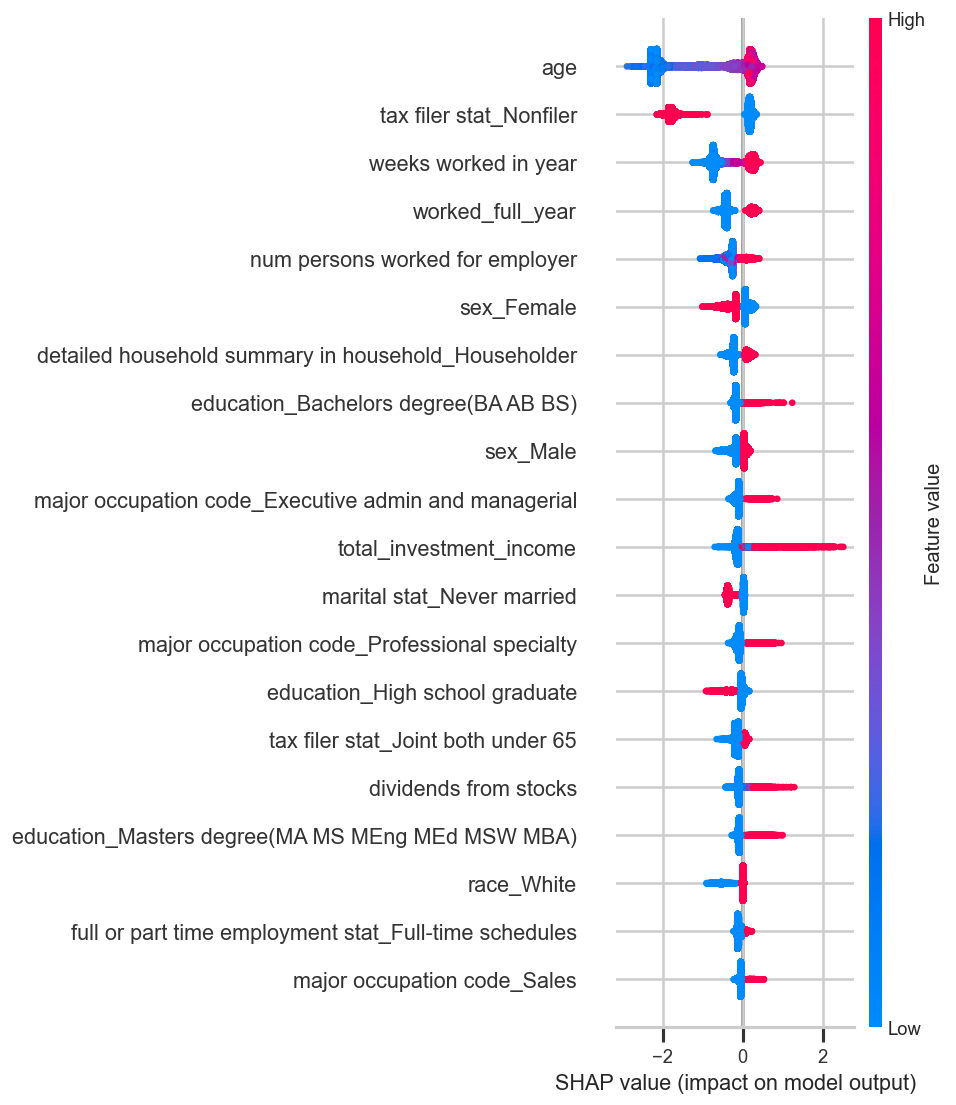


TOP 20 FEATURES (XGBoost)
                                               Feature  Importance
11                                    worked_full_year    0.247189
125                            tax filer stat_Nonfiler    0.081035
103                                           sex_Male    0.033399
6                                 weeks worked in year    0.033258
82        major occupation code_Professional specialty    0.019865
92                           hispanic origin_All other    0.018556
79                 major occupation code_Other service    0.018531
137  detailed household summary in household_Househ...    0.018271
74   major occupation code_Executive admin and mana...    0.017988
102                                         sex_Female    0.017853
35    education_Masters degree(MA MS MEng MEd MSW MBA)    0.016117
30                education_Bachelors degree(BA AB BS)    0.015235
45                          marital stat_Never married    0.014697
33                      education_H

In [36]:
best_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', models['XGBoost'])
])

best_pipeline.fit(X_train, y_train)

# SHAP for trained XGBoost

preprocessor_fitted = best_pipeline.named_steps['preprocess']
xgb_model = best_pipeline.named_steps['model']

X_test_transformed = preprocessor_fitted.transform(X_test)

num_features = numerical_features
ohe = preprocessor_fitted.named_transformers_['cat']
cat_features_ohe = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_features, cat_features_ohe])

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    max_display=20
)


ohe = best_pipeline.named_steps['preprocess'] \
                   .named_transformers_['cat']

feature_names = (
    numerical_features +
    list(ohe.get_feature_names_out(categorical_features))
)

importances = best_pipeline.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTOP 20 FEATURES (XGBoost)")

print(importance_df.head(20))

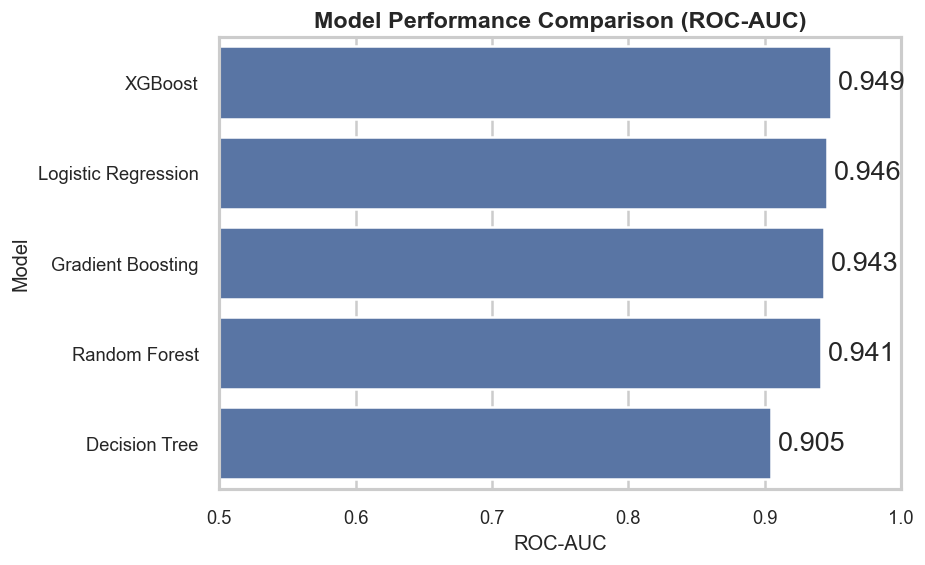

In [37]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=results_df['ROC-AUC'],
    y=results_df.index,
    orient='h'
)

plt.xlabel('ROC-AUC')
plt.ylabel('Model')
plt.title('Model Performance Comparison (ROC-AUC)', fontweight='bold')

for i, v in enumerate(results_df['ROC-AUC']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center')

plt.xlim(0.5, 1.0)
plt.tight_layout()
plt.show()


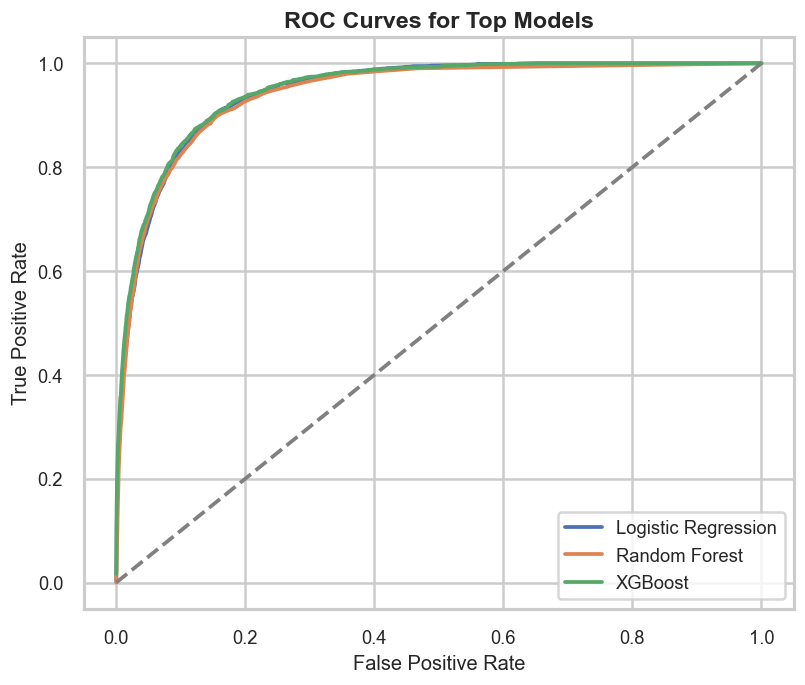

In [38]:
plt.figure(figsize=(7, 6))

for name in ['Logistic Regression', 'Random Forest', 'XGBoost']:
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', models[name])
    ])
    pipeline.fit(X_train, y_train)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    sns.lineplot(x=fpr, y=tpr, label=name)

sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top Models', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()


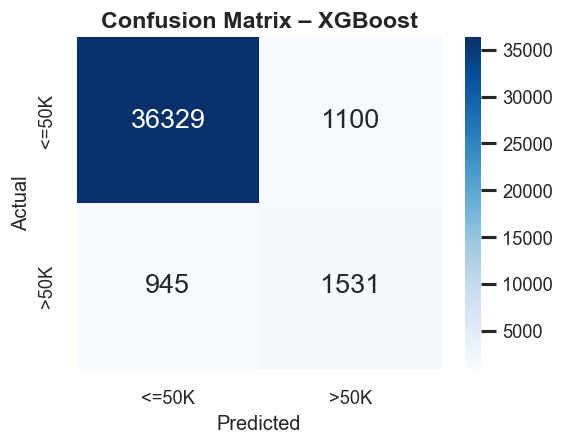

In [39]:
best_model_name = 'XGBoost'

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', models[best_model_name])
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Save the model
joblib.dump(pipeline, 'model_1_predictive_model.joblib')

# To load it later:
# loaded_model = joblib.load('model_1_predictive_model.joblib')

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['<=50K', '>50K'],
    yticklabels=['<=50K', '>50K']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – XGBoost', fontweight='bold')
plt.tight_layout()
plt.show()


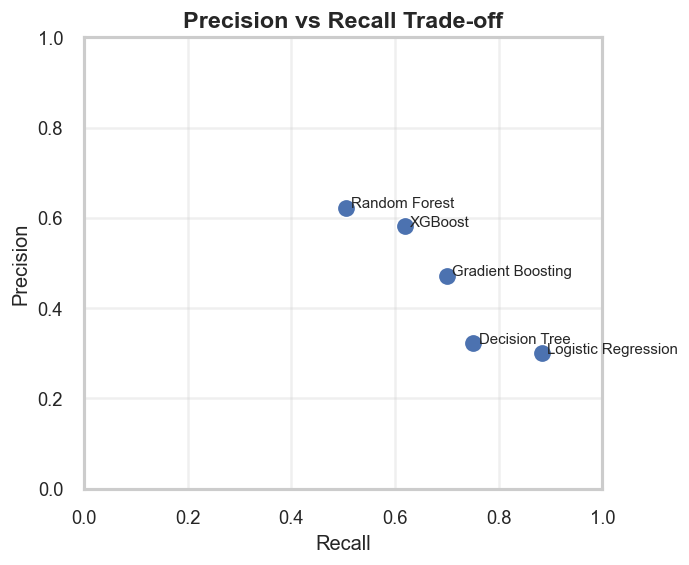

In [40]:
pr_df = pd.DataFrame(results).T.reset_index()
pr_df.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=pr_df,
    x='Recall',
    y='Precision',
    s=120
)

for _, row in pr_df.iterrows():
    plt.text(row['Recall'] + 0.01, row['Precision'], row['Model'], fontsize=9)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Trade-off', fontweight='bold')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


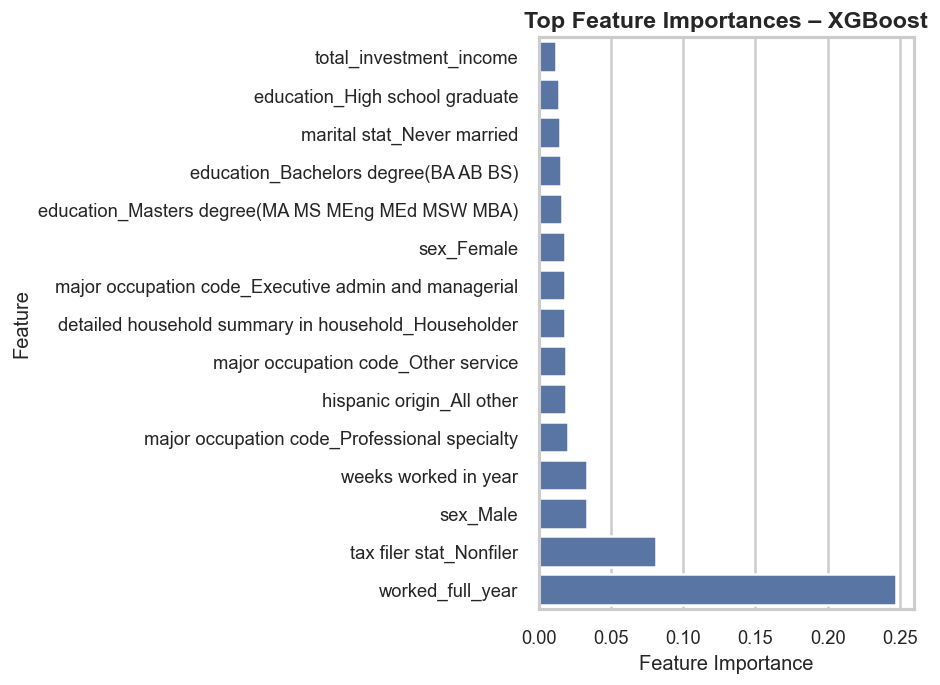

In [41]:
top_n = 15
top_features = importance_df.head(top_n).sort_values('Importance')

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_features,
    x='Importance',
    y='Feature'
)

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances – XGBoost', fontweight='bold')
plt.tight_layout()
plt.show()


### Weighted Modelling

In [42]:
# WEIGHTED MODEL COMPARISON
print("WEIGHTED VS UNWEIGHTED MODEL TRAINING")

weights_train = df.loc[X_train.index, 'weight'].values
weights_test = df.loc[X_test.index, 'weight'].values

y_prob_unweighted = best_pipeline.predict_proba(X_test)[:, 1]
auc_unweighted = roc_auc_score(y_test, y_prob_unweighted)
auc_unweighted_weval = roc_auc_score(y_test, y_prob_unweighted, sample_weight=weights_test)

print("\nTraining Weighted XGBoost (no SMOTE)...")

pipeline_weighted = SkPipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', verbosity=0))
])

pipeline_weighted.fit(X_train, y_train, model__sample_weight=weights_train)

y_prob_weighted = pipeline_weighted.predict_proba(X_test)[:, 1]
auc_weighted = roc_auc_score(y_test, y_prob_weighted)
auc_weighted_weval = roc_auc_score(y_test, y_prob_weighted, sample_weight=weights_test)

print(f"{'Model':<35} {'AUC (standard)':<20} {'AUC (weighted eval)':<20}")
print("-" * 70)
print(f"{'XGBoost + SMOTE (unweighted)':<35} {auc_unweighted:<20.4f} {auc_unweighted_weval:<20.4f}")
print(f"{'XGBoost + sample_weight':<35} {auc_weighted:<20.4f} {auc_weighted_weval:<20.4f}")

print("INTERPRETATION")

print("""
- SMOTE model: Handles class imbalance by oversampling minority class
- Weighted model: Uses sample weights to represent population distribution

Tradeoff:
- SMOTE improves minority class detection but can't use with sample_weight
- Weighted training reflects population but doesn't address class imbalance

Recommendation:
- For predicting on similar samples: Use SMOTE model
- For population-level inference: Use weighted model
""")

WEIGHTED VS UNWEIGHTED MODEL TRAINING

Training Weighted XGBoost (no SMOTE)...
Model                               AUC (standard)       AUC (weighted eval) 
----------------------------------------------------------------------
XGBoost + SMOTE (unweighted)        0.9489               0.9496              
XGBoost + sample_weight             0.9495               0.9500              
INTERPRETATION

- SMOTE model: Handles class imbalance by oversampling minority class
- Weighted model: Uses sample weights to represent population distribution

Tradeoff:
- SMOTE improves minority class detection but can't use with sample_weight
- Weighted training reflects population but doesn't address class imbalance

Recommendation:
- For predicting on similar samples: Use SMOTE model
- For population-level inference: Use weighted model



## Part II

In [43]:
X_cluster = df_model[numerical_features + categorical_features].copy()

X_cluster_transformed = preprocessor.fit_transform(X_cluster)

print(f"Clustering data shape: {X_cluster_transformed.shape}")

Clustering data shape: (199523, 286)


Components needed for 95% variance: 64


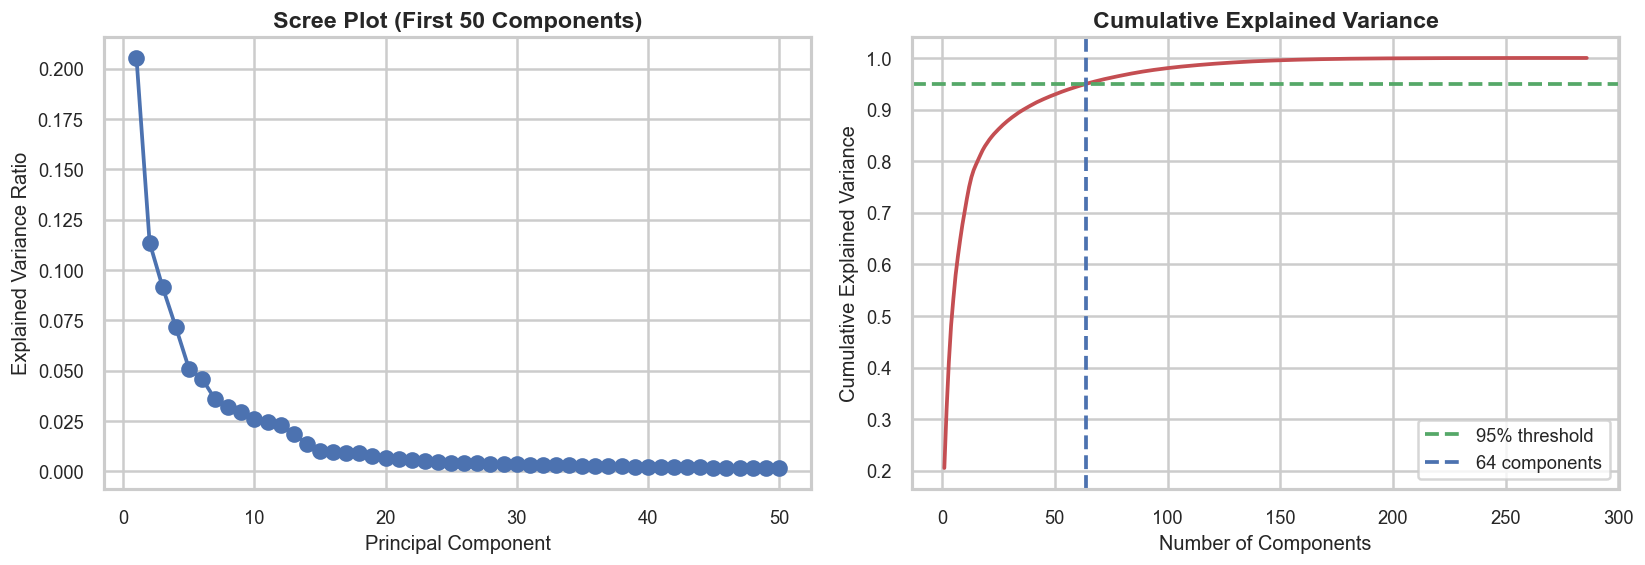

In [44]:
pca_full = PCA(random_state=42)
pca_full.fit(X_cluster_transformed)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum >= 0.95) + 1

print(f"Components needed for 95% variance: {n_components_95}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, 51), pca_full.explained_variance_ratio_[:50], 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot (First 50 Components)', fontweight='bold')

axes[1].plot(range(1, len(cumsum)+1), cumsum, 'r-')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
axes[1].axvline(x=n_components_95, color='b', linestyle='--', label=f'{n_components_95} components')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

PCA reduced shape: (199523, 30)
Variance explained: 88.1%

Finding optimal K...
  K=2: Silhouette=0.2498
  K=3: Silhouette=0.2717
  K=4: Silhouette=0.2444
  K=5: Silhouette=0.2799
  K=6: Silhouette=0.2634
  K=7: Silhouette=0.2808
  K=8: Silhouette=0.2827
  K=9: Silhouette=0.2756
  K=10: Silhouette=0.2507


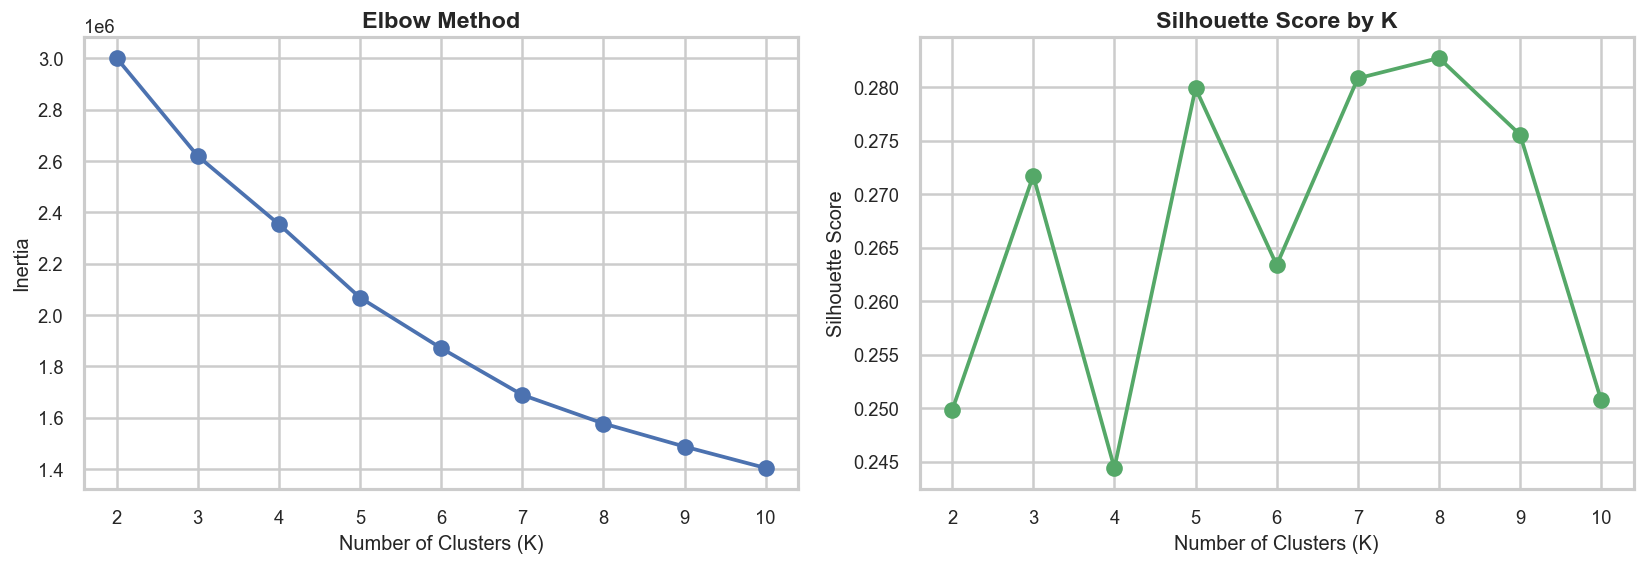


Optimal K (by silhouette): 8


In [45]:
pca = PCA(n_components=30, random_state=42)
X_pca = pca.fit_transform(X_cluster_transformed)

print(f"PCA reduced shape: {X_pca.shape}")
print(f"Variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("\nFinding optimal K...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_pca, kmeans.labels_, sample_size=10000)
    silhouette_scores.append(sil_score)
    print(f"  K={k}: Silhouette={sil_score:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method', fontweight='bold')

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score by K', fontweight='bold')

plt.tight_layout()
plt.show()

# Best K
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal K (by silhouette): {best_k}")

In [46]:
optimal_k = 5

cluster_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=30, random_state=42)),
    ('kmeans', KMeans(
        n_clusters=optimal_k,
        random_state=42,
        n_init=10
    ))
])

cluster_pipeline.fit(X_cluster)

df_model['Cluster'] = cluster_pipeline.predict(X_cluster)

print(f"Cluster Distribution:")
print(df_model['Cluster'].value_counts().sort_index())
print(f"\nCluster Percentages:")
print((df_model['Cluster'].value_counts().sort_index() / len(df_model) * 100).round(2))


joblib.dump(cluster_pipeline, "model_2_segmentation_model.joblib")
# To load it later:
# loaded_model = joblib.load('model_2_segmentation_model.joblib')


Cluster Distribution:
Cluster
0     86244
1    101917
2      3903
3       422
4      7037
Name: count, dtype: int64

Cluster Percentages:
Cluster
0    43.23
1    51.08
2     1.96
3     0.21
4     3.53
Name: count, dtype: float64


['model_2_segmentation_model.joblib']

CLUSTER PROFILES - NUMERICAL FEATURES
Cluster                               0       1        2          3        4
age                               38.89   29.37    44.17      47.89    48.66
wage per hour                    115.66    1.88    80.31      22.95    80.89
capital gains                      0.00    0.00     0.00   93082.68  6743.72
capital losses                     0.00    0.00  1905.76      16.02     0.00
dividends from stocks            146.07  120.60   638.05   10855.16  1058.96
num persons worked for employer    3.85    0.21     3.45       3.21     3.19
weeks worked in year              47.08    1.07    41.38      45.91    38.94
total_investment_income          146.07  120.60 -1267.72  103921.81  7802.68
has_capital_gains                  0.00    0.00     0.00       0.96     0.99
has_capital_losses                 0.00    0.00     1.00       0.01     0.00
has_dividends                      0.14    0.05     0.25       0.60     0.27
worked_full_year                   0.7

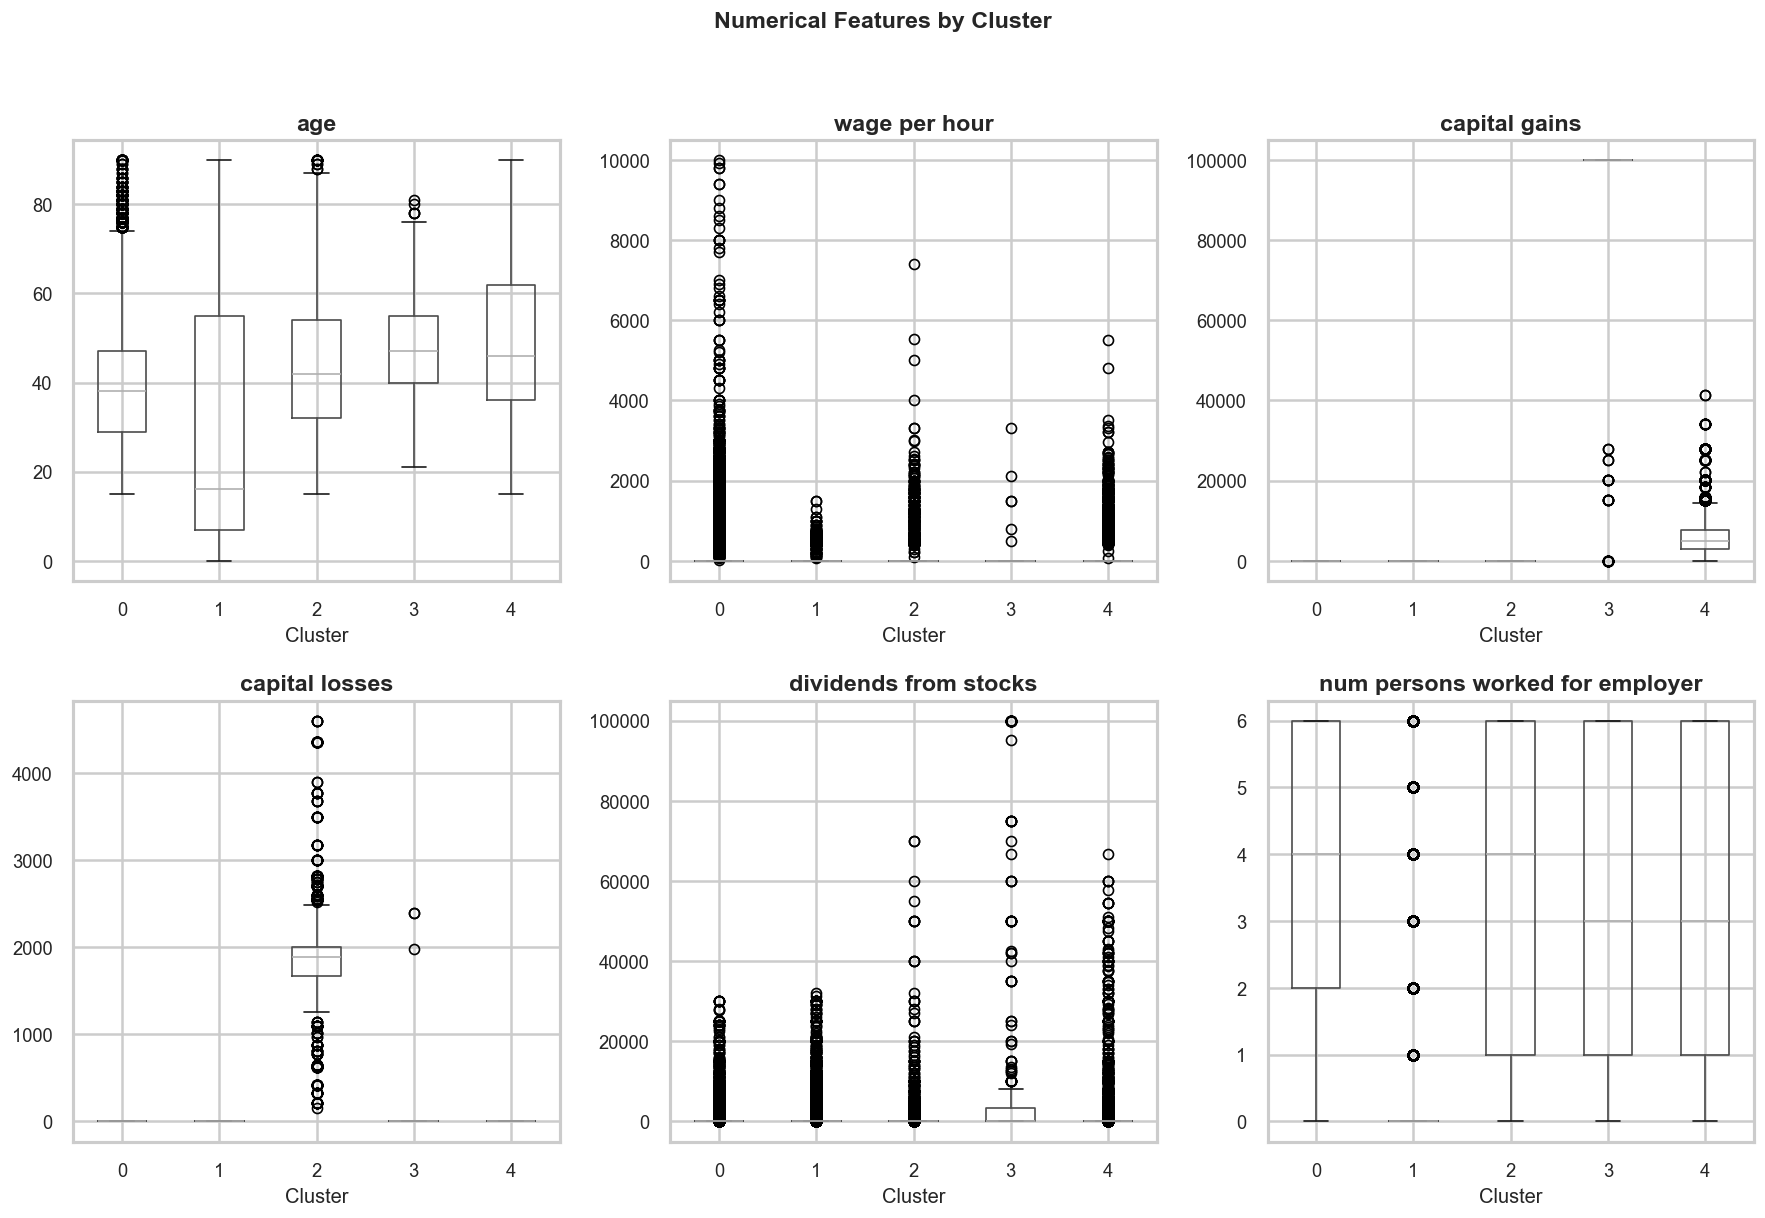

In [47]:
print("CLUSTER PROFILES - NUMERICAL FEATURES")

cluster_num_profile = df_model.groupby('Cluster')[numerical_features].mean().round(2)
print(cluster_num_profile.T)

# Visualize numerical profiles
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_features[:6]):
    df_model.boxplot(column=col, by='Cluster', ax=axes[i])
    axes[i].set_title(col, fontweight='bold')
    axes[i].set_xlabel('Cluster')

plt.suptitle('Numerical Features by Cluster', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

CLUSTER PROFILES - CATEGORICAL FEATURES (Top values per cluster)

EDUCATION:
  Cluster 0: High school graduate: 34.0%, Some college but no degree: 21.0%, Bachelors degree(BA AB BS): 16.1%
  Cluster 1: Children: 46.5%, High school graduate: 15.8%, Some college but no degree: 7.5%
  Cluster 2: High school graduate: 25.6%, Bachelors degree(BA AB BS): 20.8%, Some college but no degree: 18.7%
  Cluster 3: Bachelors degree(BA AB BS): 31.8%, Prof school degree (MD DDS DVM LLB JD): 22.5%, Masters degree(MA MS MEng MEd MSW MBA): 13.7%
  Cluster 4: High school graduate: 27.7%, Bachelors degree(BA AB BS): 21.6%, Some college but no degree: 18.0%

MARITAL STAT:
  Cluster 0: Married-civilian spouse present: 61.1%, Never married: 23.5%, Divorced: 9.7%
  Cluster 1: Never married: 63.0%, Married-civilian spouse present: 24.0%, Widowed: 7.9%
  Cluster 2: Married-civilian spouse present: 58.5%, Never married: 22.9%, Divorced: 10.7%
  Cluster 3: Married-civilian spouse present: 84.6%, Divorced: 5.9%, Nev

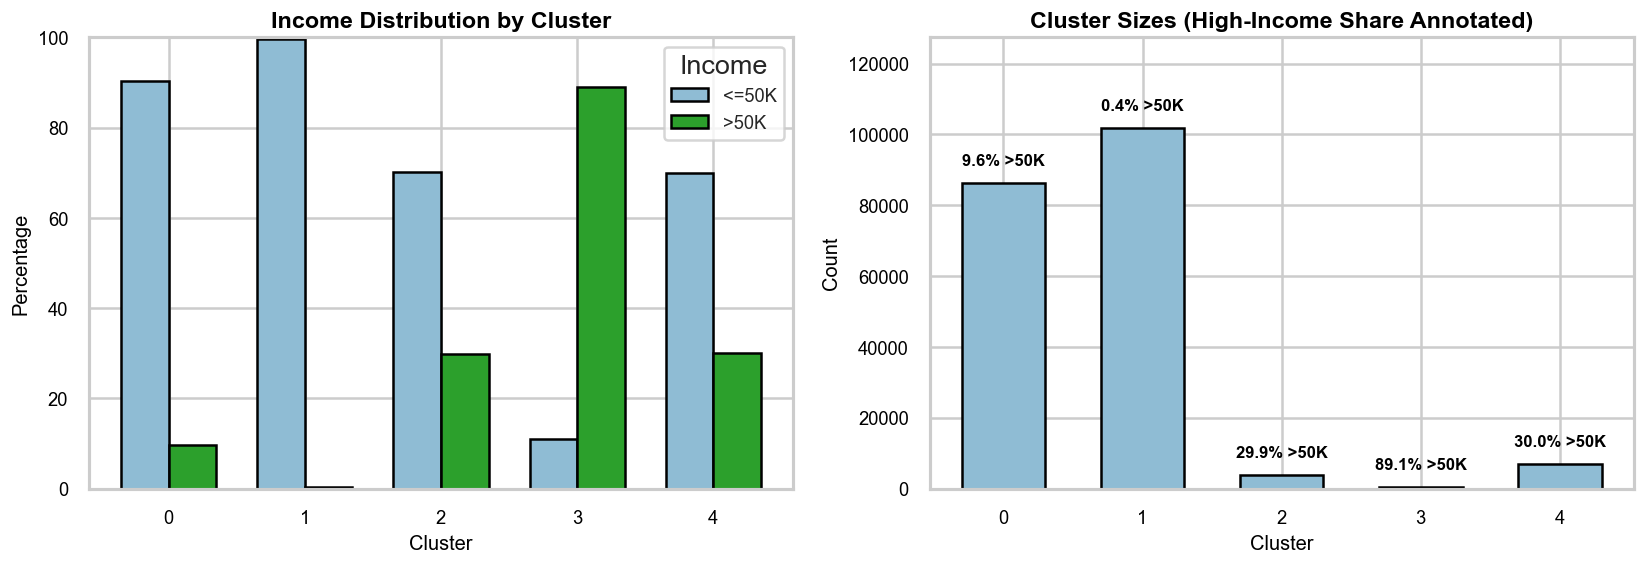

In [48]:
key_cats = ['education', 'marital stat', 'sex', 'class of worker', 'major occupation code']

print("CLUSTER PROFILES - CATEGORICAL FEATURES (Top values per cluster)")

for col in key_cats:
    print(f"\n{col.upper()}:")
    ct = pd.crosstab(df_model['Cluster'], df_model[col], normalize='index') * 100
    # Show top 3 categories per cluster
    for cluster in range(optimal_k):
        top_cats = ct.loc[cluster].nlargest(3)
        top_str = ", ".join([f"{cat}: {val:.1f}%" for cat, val in top_cats.items()])
        print(f"  Cluster {cluster}: {top_str}")

# Income distribution by cluster
print("\n" + "=" * 70)
print("INCOME DISTRIBUTION BY CLUSTER")

income_by_cluster = pd.crosstab(df_model['Cluster'], df_model['target'], normalize='index') * 100
income_by_cluster.columns = ['<=50K %', '>50K %']
print(income_by_cluster.round(2))

income_by_cluster = pd.crosstab(
    df_model["Cluster"],
    df_model["target"],
    normalize="index"
) * 100
income_by_cluster.columns = ["<=50K %", ">50K %"]

cluster_sizes = df_model["Cluster"].value_counts().sort_index()
high_income_pct = income_by_cluster[">50K %"].values
clusters = income_by_cluster.index.values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Income Distribution by Cluster (Grouped Bar Chart)
bar_width = 0.35

axes[0].bar(
    clusters - bar_width / 2,
    income_by_cluster["<=50K %"],
    width=bar_width,
    color=baseline_color,
    edgecolor="black",
    label="<=50K"
)

axes[0].bar(
    clusters + bar_width / 2,
    income_by_cluster[">50K %"],
    width=bar_width,
    color=positive_color,
    edgecolor="black",
    label=">50K"
)

axes[0].set_title(
    "Income Distribution by Cluster",
    fontweight="bold",
    color=text_color
)
axes[0].set_xlabel("Cluster", color=text_color)
axes[0].set_ylabel("Percentage", color=text_color)
axes[0].set_xticks(clusters)
axes[0].set_ylim(0, 100)
axes[0].tick_params(colors=text_color)
axes[0].legend(title="Income")

# Cluster Sizes (Annotated by High-Income Share)
bars = axes[1].bar(
    cluster_sizes.index,
    cluster_sizes.values,
    color=baseline_color,
    edgecolor="black",
    width=0.6
)

axes[1].set_title(
    "Cluster Sizes (High-Income Share Annotated)",
    fontweight="bold",
    color=text_color
)
axes[1].set_xlabel("Cluster", color=text_color)
axes[1].set_ylabel("Count", color=text_color)
axes[1].set_xticks(cluster_sizes.index)
axes[1].tick_params(colors=text_color)

max_size = cluster_sizes.max()
axes[1].set_ylim(0, max_size * 1.25)

y_offset = max_size * 0.04

for bar, pct in zip(bars, high_income_pct):
    x = bar.get_x() + bar.get_width() / 2
    height = bar.get_height()

    axes[1].text(
        x,
        height + y_offset,
        f"{pct:.1f}% >50K",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color=text_color
    )


plt.tight_layout()
plt.show()

SEGMENT SUMMARY
               Segment   Size  Size %  Avg Age  High Income %  Avg Capital Gains  Avg Dividends
    Working Mainstream  86244   43.23    38.89           9.60               0.00         146.07
      Young/Dependents 101917   51.08    29.37           0.44               0.00         120.60
 Investors with Losses   3903    1.96    44.17          29.87               0.00         638.05
Affluent Professionals    422    0.21    47.89          89.10           93082.68       10855.16
  Investors with Gains   7037    3.53    48.66          30.00            6743.72        1058.96


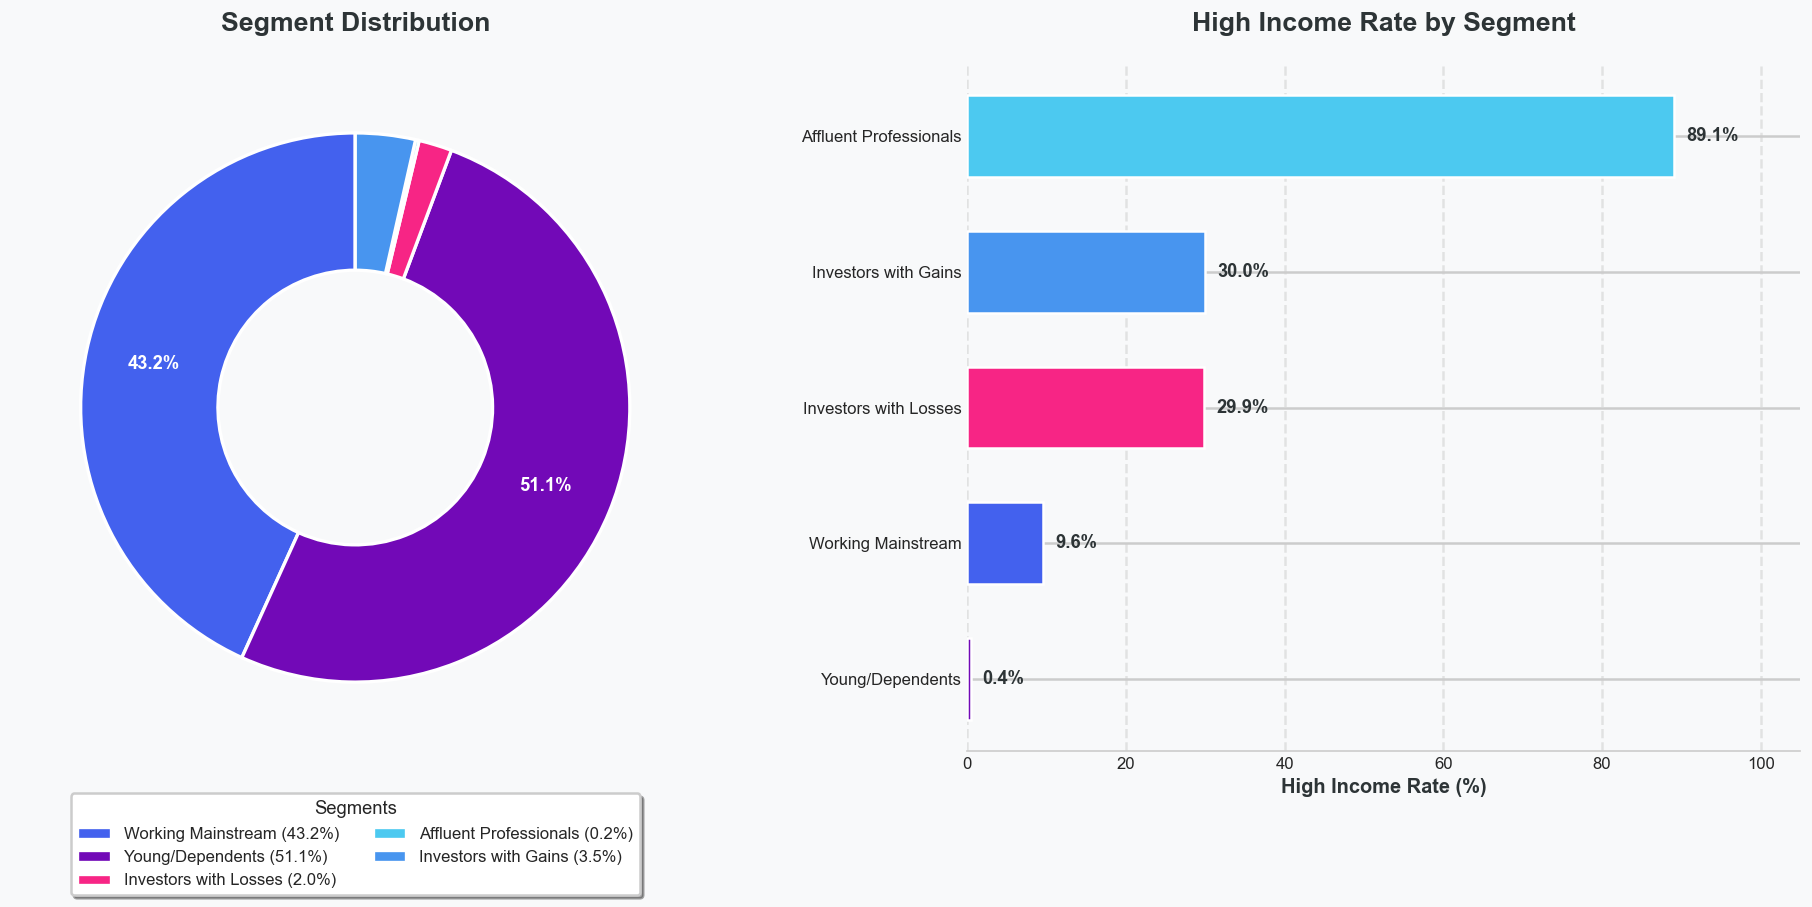

In [49]:
segment_names = {
    0: 'Working Mainstream',
    1: 'Young/Dependents',
    2: 'Investors with Losses',
    3: 'Affluent Professionals',
    4: 'Investors with Gains'
}

df_model['Segment'] = df_model['Cluster'].map(segment_names)

# Summary table
summary_data = []
for cluster in range(optimal_k):
    subset = df_model[df_model['Cluster'] == cluster]
    summary_data.append({
        'Segment': segment_names[cluster],
        'Size': len(subset),
        'Size %': len(subset) / len(df_model) * 100,
        'Avg Age': subset['age'].mean(),
        'High Income %': (subset['target'] == 1).mean() * 100,
        'Avg Capital Gains': subset['capital gains'].mean(),
        'Avg Dividends': subset['dividends from stocks'].mean()
    })

summary_df = pd.DataFrame(summary_data).round(2)
print("SEGMENT SUMMARY")
print(summary_df.to_string(index=False))

# Visualization
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.patch.set_facecolor('#f8f9fa')

colors = ['#4361ee', '#7209b7', '#f72585', '#4cc9f0', '#4895ef']

sizes = [len(df_model[df_model['Cluster'] == i]) for i in range(optimal_k)]
wedges, texts, autotexts = axes[0].pie(
    sizes, 
    labels=None,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 5 else '',
    colors=colors, 
    startangle=90,
    pctdistance=0.75,
    wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2)
)

for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

legend_labels = [f"{segment_names[i]} ({sizes[i]/sum(sizes)*100:.1f}%)" for i in range(optimal_k)]
axes[0].legend(
    wedges, 
    legend_labels,
    title="Segments",
    title_fontsize=11,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    fontsize=10,
    frameon=True,
    fancybox=True,
    shadow=True,
    ncol=2
)

axes[0].set_title('Segment Distribution', fontsize=16, fontweight='bold', pad=20, color='#2d3436')

segments = [segment_names[i] for i in range(optimal_k)]
high_income_pcts = [summary_data[i]['High Income %'] for i in range(optimal_k)]

# Sort by high income %
sorted_indices = sorted(range(len(high_income_pcts)), key=lambda i: high_income_pcts[i])
sorted_segments = [segments[i] for i in sorted_indices]
sorted_pcts = [high_income_pcts[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

bars = axes[1].barh(sorted_segments, sorted_pcts, color=sorted_colors, edgecolor='white', height=0.6)

axes[1].set_xlabel('High Income Rate (%)', fontsize=12, fontweight='bold', color='#2d3436')
axes[1].set_title('High Income Rate by Segment', fontsize=16, fontweight='bold', pad=20, color='#2d3436')
axes[1].set_xlim(0, 105)
axes[1].set_facecolor('#f8f9fa')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].tick_params(axis='y', length=0)
axes[1].tick_params(axis='both', labelsize=10)

for bar, pct in zip(bars, sorted_pcts):
    axes[1].text(
        pct + 1.5, 
        bar.get_y() + bar.get_height()/2, 
        f'{pct:.1f}%', 
        va='center', 
        fontsize=11, 
        fontweight='bold',
        color='#2d3436'
    )

axes[1].xaxis.grid(True, linestyle='--', alpha=0.5)
axes[1].set_axisbelow(True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

### Weighted Modelling

In [50]:
# WEIGHTED SEGMENT ANALYSIS
print("WEIGHTED SEGMENT ANALYSIS")

df['Cluster'] = df_model['Cluster'].values
df['Segment'] = df['Cluster'].map(segment_names)

print("\nSEGMENT SIZE - SAMPLE VS POPULATION:")
print("-" * 65)
print(f"{'Segment':<25} {'Sample %':>12} {'Population %':>15} {'Diff':>10}")
print("-" * 65)

for cluster in range(5):
    sample_pct = (df['Cluster'] == cluster).mean() * 100
    pop_pct = df[df['Cluster'] == cluster]['weight'].sum() / df['weight'].sum() * 100
    diff = pop_pct - sample_pct
    print(f"{segment_names[cluster]:<25} {sample_pct:>12.2f} {pop_pct:>15.2f} {diff:>+10.2f}")

# Weighted income by segment
print("\n\nHIGH INCOME % BY SEGMENT - SAMPLE VS POPULATION:")
print("-" * 65)
print(f"{'Segment':<25} {'Sample %':>12} {'Population %':>15} {'Diff':>10}")
print("-" * 65)

for cluster in range(5):
    subset = df[df['Cluster'] == cluster]
    sample_income = (subset['target'] == 1).mean() * 100
    weighted_income = np.average(subset['target'], weights=subset['weight']) * 100
    diff = weighted_income - sample_income
    print(f"{segment_names[cluster]:<25} {sample_income:>12.2f} {weighted_income:>15.2f} {diff:>+10.2f}")

print("INTERPRETATION")

print("""
Small differences between sample and population percentages confirm
that our segmentation findings generalize well to the US population.

Key insight: The segments we identified in the sample accurately
represent real population groups for marketing targeting.
""")

WEIGHTED SEGMENT ANALYSIS

SEGMENT SIZE - SAMPLE VS POPULATION:
-----------------------------------------------------------------
Segment                       Sample %    Population %       Diff
-----------------------------------------------------------------
Working Mainstream               43.23           44.09      +0.86
Young/Dependents                 51.08           50.13      -0.95
Investors with Losses             1.96            2.03      +0.07
Affluent Professionals            0.21            0.21      +0.00
Investors with Gains              3.53            3.54      +0.01


HIGH INCOME % BY SEGMENT - SAMPLE VS POPULATION:
-----------------------------------------------------------------
Segment                       Sample %    Population %       Diff
-----------------------------------------------------------------
Working Mainstream                9.60            9.75      +0.15
Young/Dependents                  0.44            0.45      +0.02
Investors with Losses      